In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from cifar_model import generator,discriminator,cnn
import utils

In [3]:
'''
build unl data pipeline 
train gan cifar10 kinglsey
generate adv pert
train takeru or simple cnn cifar
get gains !
'''

'\nbuild unl data pipeline \ntrain gan cifar10 kinglsey\ngenerate adv pert\ntrain takeru or simple cnn cifar\nget gains !\n'

In [4]:
params = dict(
    batch_size = 50,
    seed = 1234,
    z_dim = 100,
    lr = 1e-4,
    logdir = 'cifar_gans/',
    name_model = 'model_kingsley'
)
rng = np.random.RandomState(params['seed'])  # seed labels

In [20]:
params_dnn = dict(
    batch=50,
    lr = 1e-4,
    labeled = 100,
    seed = 1234,
    epoch=801
)

In [6]:
def plot_dics(l):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    names=[]
    for var in ['train','test','ema']:
        for d in l:
            x=d.item().get(var)
            plt.plot(x)
            names.append(var + '_' + d.item().get('name'))
    plt.legend(names)
    plt.subplot(122)
    names=[]
    for var in ['loss','mani']:
        for d in l:
            x=d.item().get(var)
            plt.plot(x)
            names.append(var + '_' + d.item().get('name'))
            plt.legend(names)

## Data

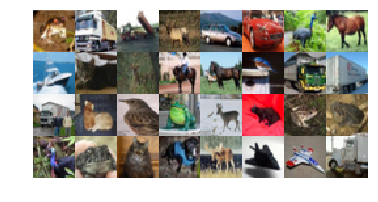

In [7]:
(trainx, trainy), (testx, testy) = tf.keras.datasets.cifar10.load_data()
def rescale(mat):
    return ((-127.5 + mat) / 127.5)
trainx = rescale(trainx)
testx = rescale(testx)
trainy = np.squeeze(trainy)
testy = np.squeeze(testy)
trainx_unl = trainx.copy()
nr_batch_unl = trainx_unl.shape[0] // params['batch_size']
utils.show_cifar(trainx_unl[:32])

train: (1000, 32, 32, 3) test: (10000, 32, 32, 3)


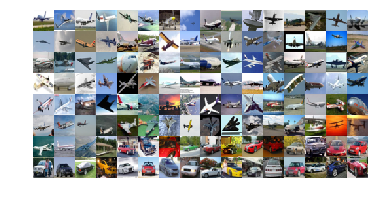

In [8]:
inds = rng.permutation(trainx.shape[0])
trainx = trainx[inds]
trainy = trainy[inds]
txs = []
tys = []
for j in range(10):
    txs.append(trainx[trainy == j][:params_dnn['labeled']])
    tys.append(trainy[trainy == j][:params_dnn['labeled']])
txs = np.concatenate(txs, axis=0)
tys = np.concatenate(tys, axis=0)
trainx = txs
trainy = tys
nr_batch_train = trainx.shape[0] // params_dnn['batch']
nr_batch_test = testx.shape[0] // params_dnn['batch']
print('train:',trainx.shape,'test:',testx.shape)
utils.show_cifar(trainx[:128])

## GAN training

In [9]:
unl = tf.placeholder(tf.float32, [params['batch_size'], 32,32,3])
is_training_pl = tf.placeholder(tf.bool, [], name='is_training_pl')
noise = tf.random_normal(shape=[params['batch_size'],params['z_dim']])

samples = generator(noise,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
real_score = discriminator(unl,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
fake_score = discriminator(samples,is_training=is_training_pl,reuse=tf.AUTO_REUSE)

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator") 

loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score,labels=tf.ones_like(fake_score)))
loss_d = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score,labels=tf.ones_like(fake_score)))+\
tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score,labels=tf.zeros_like(fake_score)))

optimizer = tf.train.AdamOptimizer(learning_rate=params['lr'], beta1=0.5)

update_ops_gen = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
update_ops_dis = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')

with tf.control_dependencies(update_ops_gen): # attached op for moving average batch norm
    traing = optimizer.minimize(loss_g,var_list=gen_vars)
with tf.control_dependencies(update_ops_dis):
    traind = optimizer.minimize(loss_d,var_list=disc_vars)

In [10]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [11]:
saver = tf.train.Saver()

In [12]:
path = './gan_cifar_saved/'
if tf.train.latest_checkpoint(path) is not None:
    path = saver.restore(sess, tf.train.latest_checkpoint(path))
else:
    print('no model found')

INFO:tensorflow:Restoring parameters from ./gan_cifar_saved/kingsley


In [13]:
# viz_every = 500
# for epoch in tqdm(range(10001)):
#     trainx_unl = trainx_unl[rng.permutation(trainx_unl.shape[0])]  # shuffling unl dataset   
    
#     for step in range(nr_batch_unl):
#         ran_from = step * params['batch_size']
#         ran_to = (step + 1) * params['batch_size']
#         sess.run(traind,{is_training_pl:True,unl:trainx_unl[ran_from:ran_to]})
#         sess.run(traing,{is_training_pl:True,unl:trainx_unl[ran_from:ran_to]})

#         if (step) % viz_every == 0:
#             xx, yy = sess.run([unl,samples],{is_training_pl:False,unl:trainx_unl[ran_from:ran_to]})
#             plt.figure(figsize=(15,5))
#             plt.subplot(121)
#             utils.show_cifar(xx[:32])
#             plt.subplot(122)
#             utils.show_cifar(yy[:32])
#             plt.show()


In [14]:
# saver.save(sess, './gan_cifar_saved/kingsley')

## Vizualization manifold examples

In [15]:
# ############ MANIFOLD ##########
z1 = tf.random_normal(shape=[params['batch_size'],params['z_dim']])
pert_n = tf.nn.l2_normalize(tf.random_normal(shape=[params['batch_size'],params['z_dim']]),dim=[1])
z1_pert = z1 + 1. * pert_n
pz = tf.random_normal([params['batch_size'],32,32,1],stddev=0.2) 

samp_z1 = generator(z1,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
samp_z2 = generator(z1_pert,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
samp_adv = samp_z1 + 10.* tf.nn.l2_normalize(samp_z2-samp_z1,dim=[1,2,3])


In [16]:
xx,yy = sess.run([samp_z1,samp_adv],{is_training_pl:False})
xx = (xx+1.)/2.
yy = (yy+1.)/2.
yy[yy>1.]=1
yy[yy<0]=0

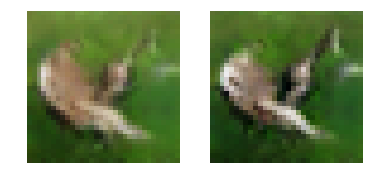

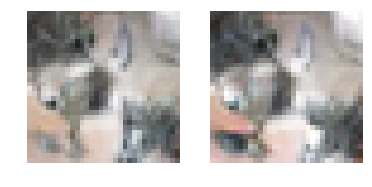

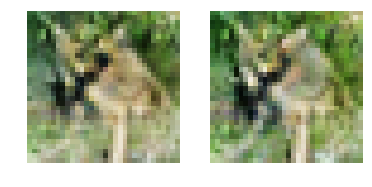

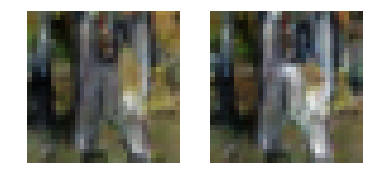

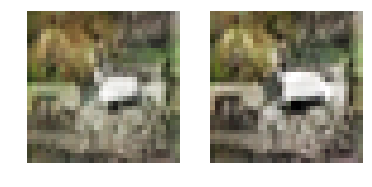

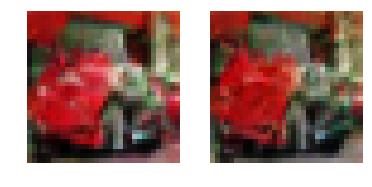

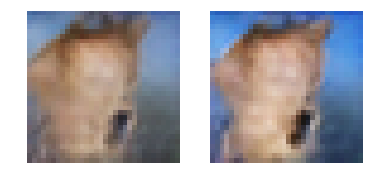

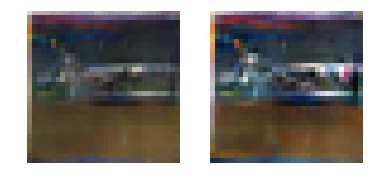

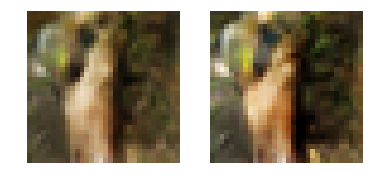

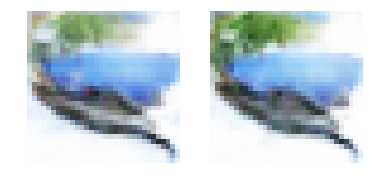

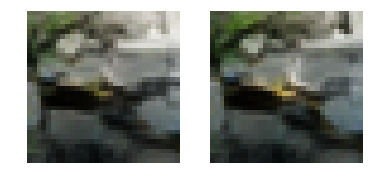

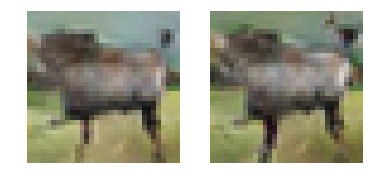

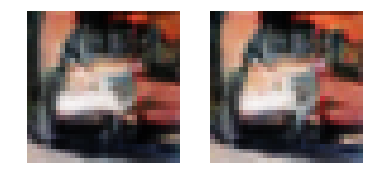

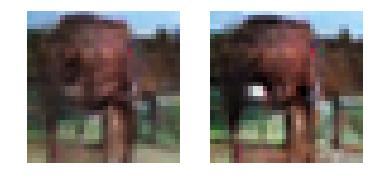

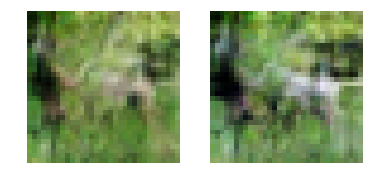

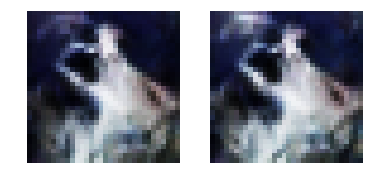

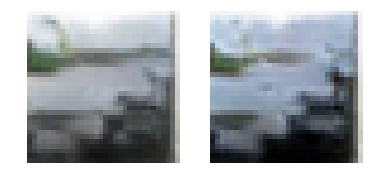

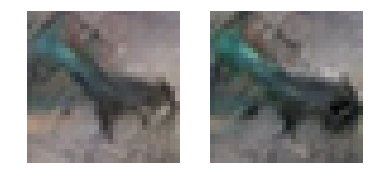

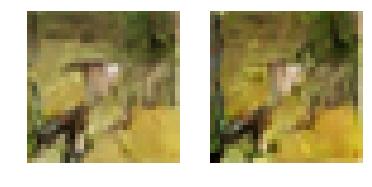

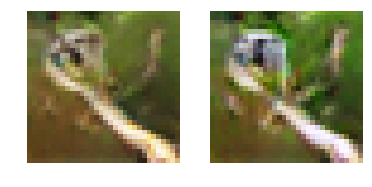

In [17]:
for idx in range(20):
    plt.subplot(1,2,1)
    plt.imshow(np.squeeze(xx[idx]))
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(yy[idx]))
    plt.axis('off')
    plt.show()

## Training CNN

In [18]:
inp = tf.placeholder(tf.float32, [params_dnn['batch'], 32,32,3])
lbl = tf.placeholder(tf.int64, [params_dnn['batch']])
# ma_decay = tf.placeholder(tf.float32,[],name='ma_decay_pl')
training_cnn  = tf.placeholder(tf.bool,[])
logits = cnn(inp,training_cnn)
xloss = tf.losses.sparse_softmax_cross_entropy(logits=logits,labels=lbl)

In [19]:
logits_z1= cnn(samp_z1,training_cnn)
logits_z2 = cnn(samp_z2+pz,training_cnn)
logits_adv = cnn(samp_adv,training_cnn) # ADD PZ 

manifold = tf.reduce_sum(tf.sqrt(tf.square(logits_z1-logits_adv)+1e-8),axis=1)
manifold_loss = tf.reduce_mean(manifold)

In [21]:
loss = xloss + 0.005 * manifold_loss

In [22]:
with tf.variable_scope("adam",reuse=tf.AUTO_REUSE):
    global_step = tf.Variable(0, name='global_step',trainable=False)
    optimizer = tf.train.AdamOptimizer(learning_rate=params_dnn['lr'])
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS,scope='classifier')  # control dependencies for batch norm ops
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(loss,var_list=tf.trainable_variables(scope='classifier'),global_step=global_step)
        
correct_prediction = tf.equal(tf.argmax(logits,1),lbl)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [23]:
ema = tf.train.ExponentialMovingAverage(decay=0.99)
dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='classifier')
maintain_averages_op = ema.apply(dvars)

with tf.control_dependencies([train_op]):
    train_op = tf.group(maintain_averages_op)

def ema_getter(getter, name, *args, **kwargs):
    var = getter(name, *args, **kwargs)
    ema_var = ema.average(var)
    return ema_var if ema_var else var 
    
logits_ema = cnn(inp, training_cnn, getter=ema_getter)
correct_prediction_ema = tf.equal(tf.argmax(logits_ema,1),lbl)
accuracy_ema = tf.reduce_mean(tf.cast(correct_prediction_ema, tf.float32))

In [24]:
#init
var = tf.global_variables(scope='classifier')+tf.global_variables(scope='adam')
init_op = tf.variables_initializer(var_list=var)

In [25]:
sess.run(init_op)
name_experiment = './100lbl_cifar/g0.005_e5_eta1.npy'
train_array = [];test_array=[]; loss_array=[]; manifold_array=[];test_array_ema=[]

Epoch: 0,global_stp: 20, xloss: 2.24740, maniloss: 1.73665, train: 13.00%, test: 10.00,test_ma: 10.00%


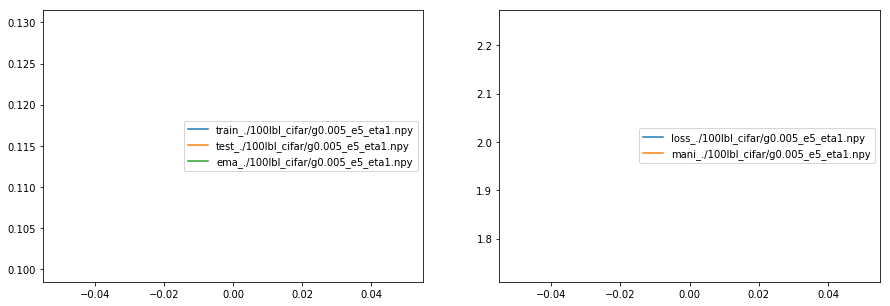

Epoch: 1,global_stp: 40, xloss: 2.03469, maniloss: 2.12938, train: 25.70%, test: 16.63,test_ma: 10.00%
Epoch: 2,global_stp: 60, xloss: 1.91711, maniloss: 2.33961, train: 30.60%, test: 15.01,test_ma: 11.14%
Epoch: 3,global_stp: 80, xloss: 1.83451, maniloss: 2.43661, train: 34.60%, test: 14.16,test_ma: 14.69%
Epoch: 4,global_stp: 100, xloss: 1.76510, maniloss: 2.62827, train: 35.90%, test: 15.13,test_ma: 14.72%
Epoch: 5,global_stp: 120, xloss: 1.70486, maniloss: 2.79724, train: 39.50%, test: 18.22,test_ma: 15.21%
Epoch: 6,global_stp: 140, xloss: 1.63480, maniloss: 2.99605, train: 42.30%, test: 23.47,test_ma: 15.57%
Epoch: 7,global_stp: 160, xloss: 1.59470, maniloss: 3.16897, train: 43.70%, test: 25.00,test_ma: 15.86%
Epoch: 8,global_stp: 180, xloss: 1.56012, maniloss: 3.30248, train: 44.90%, test: 26.14,test_ma: 16.17%
Epoch: 9,global_stp: 200, xloss: 1.51470, maniloss: 3.42019, train: 47.00%, test: 27.67,test_ma: 16.86%
Epoch: 10,global_stp: 220, xloss: 1.47595, maniloss: 3.38464, train

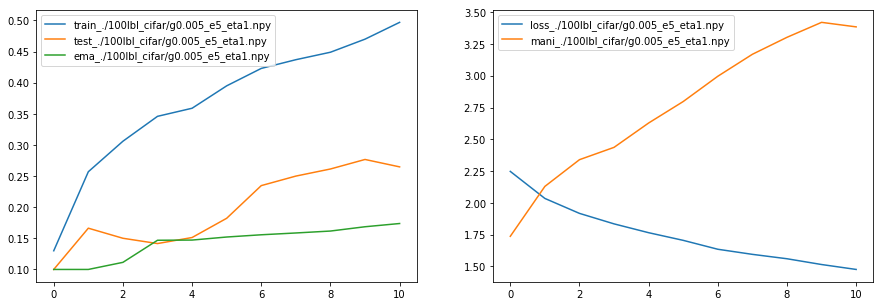

Epoch: 11,global_stp: 240, xloss: 1.43013, maniloss: 3.65920, train: 48.80%, test: 28.04,test_ma: 18.74%
Epoch: 12,global_stp: 260, xloss: 1.38507, maniloss: 3.78699, train: 50.90%, test: 28.94,test_ma: 20.08%
Epoch: 13,global_stp: 280, xloss: 1.37289, maniloss: 3.85677, train: 52.20%, test: 28.63,test_ma: 21.12%
Epoch: 14,global_stp: 300, xloss: 1.36770, maniloss: 3.84011, train: 52.60%, test: 27.70,test_ma: 23.11%
Epoch: 15,global_stp: 320, xloss: 1.34150, maniloss: 3.90368, train: 52.30%, test: 29.29,test_ma: 23.56%
Epoch: 16,global_stp: 340, xloss: 1.30919, maniloss: 3.99547, train: 56.50%, test: 29.26,test_ma: 25.00%
Epoch: 17,global_stp: 360, xloss: 1.27254, maniloss: 4.17790, train: 56.80%, test: 27.94,test_ma: 25.64%
Epoch: 18,global_stp: 380, xloss: 1.26759, maniloss: 4.17809, train: 55.10%, test: 29.05,test_ma: 26.10%
Epoch: 19,global_stp: 400, xloss: 1.22056, maniloss: 4.31750, train: 59.70%, test: 30.49,test_ma: 26.87%
Epoch: 20,global_stp: 420, xloss: 1.20718, maniloss: 4.

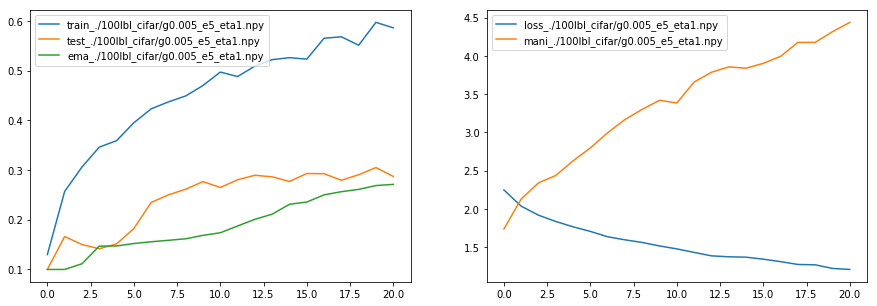

Epoch: 21,global_stp: 440, xloss: 1.16267, maniloss: 4.48149, train: 60.90%, test: 29.36,test_ma: 27.11%
Epoch: 22,global_stp: 460, xloss: 1.17068, maniloss: 4.61617, train: 61.40%, test: 29.24,test_ma: 27.63%
Epoch: 23,global_stp: 480, xloss: 1.14769, maniloss: 4.64872, train: 61.40%, test: 29.75,test_ma: 27.06%
Epoch: 24,global_stp: 500, xloss: 1.10055, maniloss: 4.76148, train: 60.80%, test: 31.00,test_ma: 27.22%
Epoch: 25,global_stp: 520, xloss: 1.10571, maniloss: 4.75448, train: 63.10%, test: 28.84,test_ma: 27.11%
Epoch: 26,global_stp: 540, xloss: 1.05173, maniloss: 5.01892, train: 64.80%, test: 32.08,test_ma: 26.88%
Epoch: 27,global_stp: 560, xloss: 1.07749, maniloss: 4.90243, train: 62.90%, test: 27.41,test_ma: 27.24%
Epoch: 28,global_stp: 580, xloss: 1.01238, maniloss: 5.01016, train: 65.60%, test: 33.36,test_ma: 28.55%
Epoch: 29,global_stp: 600, xloss: 1.03809, maniloss: 5.03977, train: 67.30%, test: 28.97,test_ma: 28.58%
Epoch: 30,global_stp: 620, xloss: 1.00836, maniloss: 5.

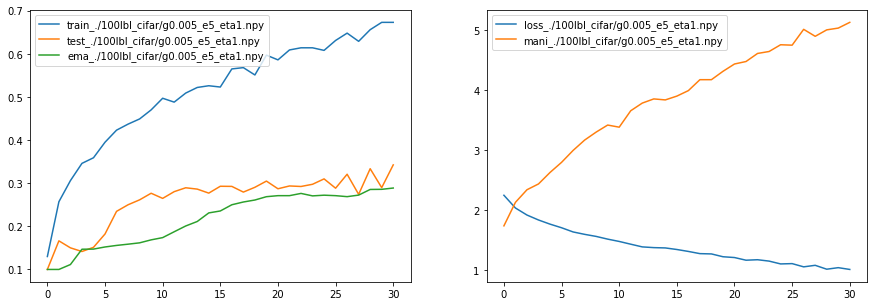

Epoch: 31,global_stp: 640, xloss: 0.96769, maniloss: 5.17192, train: 68.40%, test: 30.22,test_ma: 28.13%
Epoch: 32,global_stp: 660, xloss: 0.93292, maniloss: 5.29950, train: 68.40%, test: 33.96,test_ma: 28.77%
Epoch: 33,global_stp: 680, xloss: 0.96243, maniloss: 5.35202, train: 68.10%, test: 29.63,test_ma: 29.34%
Epoch: 34,global_stp: 700, xloss: 0.90389, maniloss: 5.37398, train: 70.20%, test: 29.18,test_ma: 29.51%
Epoch: 35,global_stp: 720, xloss: 0.89898, maniloss: 5.66179, train: 71.60%, test: 29.89,test_ma: 29.98%
Epoch: 36,global_stp: 740, xloss: 0.89428, maniloss: 5.66930, train: 70.00%, test: 34.49,test_ma: 30.24%
Epoch: 37,global_stp: 760, xloss: 0.87226, maniloss: 5.60122, train: 73.60%, test: 28.66,test_ma: 30.80%
Epoch: 38,global_stp: 780, xloss: 0.87530, maniloss: 5.51090, train: 71.40%, test: 31.26,test_ma: 31.30%
Epoch: 39,global_stp: 800, xloss: 0.85763, maniloss: 5.79414, train: 72.80%, test: 33.55,test_ma: 31.63%
Epoch: 40,global_stp: 820, xloss: 0.84608, maniloss: 5.

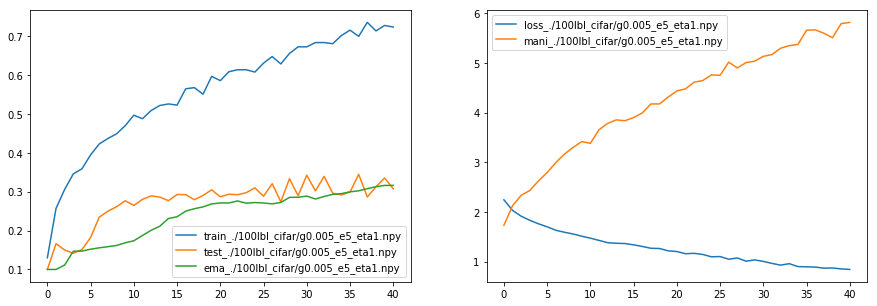

Epoch: 41,global_stp: 840, xloss: 0.81581, maniloss: 5.84304, train: 73.70%, test: 32.59,test_ma: 31.68%
Epoch: 42,global_stp: 860, xloss: 0.79051, maniloss: 5.81613, train: 73.70%, test: 31.56,test_ma: 32.38%
Epoch: 43,global_stp: 880, xloss: 0.79981, maniloss: 5.84664, train: 75.30%, test: 32.08,test_ma: 31.63%
Epoch: 44,global_stp: 900, xloss: 0.81209, maniloss: 5.97737, train: 75.00%, test: 29.36,test_ma: 31.79%
Epoch: 45,global_stp: 920, xloss: 0.79021, maniloss: 6.11922, train: 75.10%, test: 31.14,test_ma: 31.95%
Epoch: 46,global_stp: 940, xloss: 0.75911, maniloss: 5.95330, train: 76.80%, test: 30.87,test_ma: 32.50%
Epoch: 47,global_stp: 960, xloss: 0.73852, maniloss: 6.15649, train: 77.20%, test: 30.04,test_ma: 32.55%
Epoch: 48,global_stp: 980, xloss: 0.72438, maniloss: 6.22341, train: 78.70%, test: 30.14,test_ma: 32.78%
Epoch: 49,global_stp: 1000, xloss: 0.69718, maniloss: 6.27247, train: 77.90%, test: 31.84,test_ma: 32.75%
Epoch: 50,global_stp: 1020, xloss: 0.71996, maniloss: 

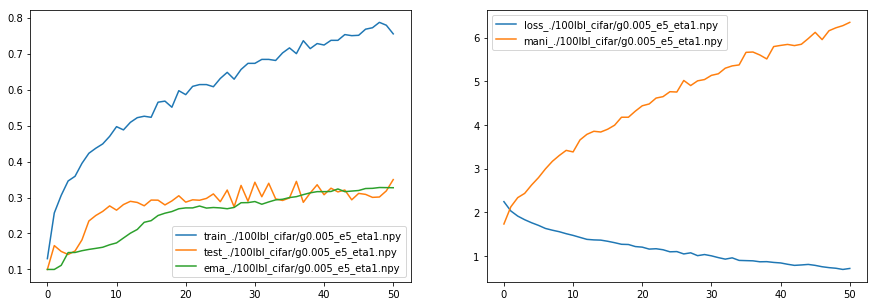

Epoch: 51,global_stp: 1040, xloss: 0.68333, maniloss: 6.35544, train: 78.00%, test: 30.52,test_ma: 32.62%
Epoch: 52,global_stp: 1060, xloss: 0.69150, maniloss: 6.24211, train: 79.60%, test: 32.73,test_ma: 32.47%
Epoch: 53,global_stp: 1080, xloss: 0.64252, maniloss: 6.34074, train: 80.30%, test: 30.54,test_ma: 32.53%
Epoch: 54,global_stp: 1100, xloss: 0.63208, maniloss: 6.48294, train: 81.00%, test: 30.85,test_ma: 32.80%
Epoch: 55,global_stp: 1120, xloss: 0.62108, maniloss: 6.57079, train: 81.20%, test: 33.80,test_ma: 33.11%
Epoch: 56,global_stp: 1140, xloss: 0.63063, maniloss: 6.71257, train: 80.80%, test: 31.95,test_ma: 33.93%
Epoch: 57,global_stp: 1160, xloss: 0.65095, maniloss: 6.82557, train: 78.60%, test: 32.50,test_ma: 34.46%
Epoch: 58,global_stp: 1180, xloss: 0.60036, maniloss: 6.69324, train: 81.00%, test: 35.57,test_ma: 33.76%
Epoch: 59,global_stp: 1200, xloss: 0.59404, maniloss: 6.65567, train: 81.40%, test: 34.56,test_ma: 34.14%
Epoch: 60,global_stp: 1220, xloss: 0.60117, ma

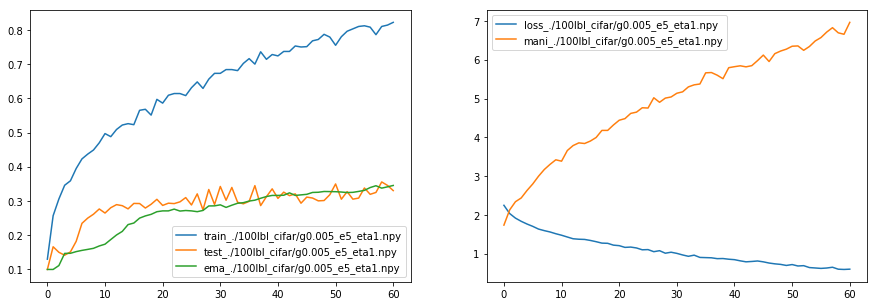

Epoch: 61,global_stp: 1240, xloss: 0.61687, maniloss: 7.02180, train: 81.40%, test: 32.03,test_ma: 33.40%
Epoch: 62,global_stp: 1260, xloss: 0.57659, maniloss: 6.92900, train: 82.90%, test: 33.84,test_ma: 33.97%
Epoch: 63,global_stp: 1280, xloss: 0.54102, maniloss: 6.95288, train: 85.40%, test: 33.10,test_ma: 33.25%
Epoch: 64,global_stp: 1300, xloss: 0.54035, maniloss: 7.03336, train: 84.30%, test: 34.33,test_ma: 35.02%
Epoch: 65,global_stp: 1320, xloss: 0.50579, maniloss: 7.07633, train: 85.30%, test: 33.80,test_ma: 34.52%
Epoch: 66,global_stp: 1340, xloss: 0.48929, maniloss: 7.26289, train: 86.80%, test: 35.17,test_ma: 34.95%
Epoch: 67,global_stp: 1360, xloss: 0.47014, maniloss: 7.27924, train: 86.90%, test: 31.52,test_ma: 35.15%
Epoch: 68,global_stp: 1380, xloss: 0.49241, maniloss: 7.33502, train: 86.60%, test: 33.98,test_ma: 35.88%
Epoch: 69,global_stp: 1400, xloss: 0.50180, maniloss: 7.37718, train: 84.80%, test: 32.26,test_ma: 36.84%
Epoch: 70,global_stp: 1420, xloss: 0.44597, ma

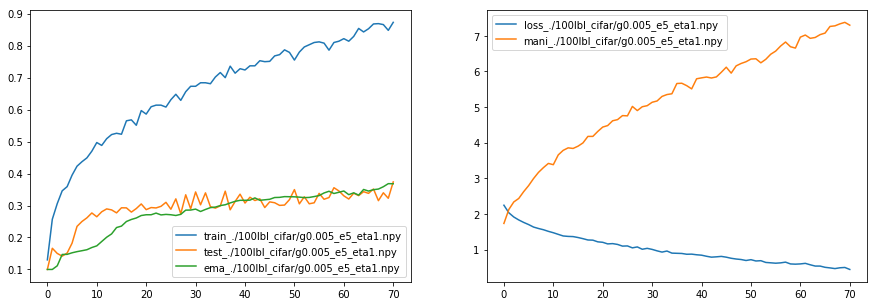

Epoch: 71,global_stp: 1440, xloss: 0.45195, maniloss: 7.41085, train: 88.10%, test: 35.33,test_ma: 36.70%
Epoch: 72,global_stp: 1460, xloss: 0.43231, maniloss: 7.72063, train: 88.00%, test: 34.05,test_ma: 35.97%
Epoch: 73,global_stp: 1480, xloss: 0.44051, maniloss: 7.52559, train: 88.50%, test: 39.57,test_ma: 36.13%
Epoch: 74,global_stp: 1500, xloss: 0.44908, maniloss: 7.62904, train: 88.20%, test: 32.20,test_ma: 34.28%
Epoch: 75,global_stp: 1520, xloss: 0.41775, maniloss: 7.61455, train: 88.20%, test: 34.63,test_ma: 33.64%
Epoch: 76,global_stp: 1540, xloss: 0.42655, maniloss: 7.63263, train: 87.20%, test: 32.30,test_ma: 34.91%
Epoch: 77,global_stp: 1560, xloss: 0.39484, maniloss: 7.66633, train: 89.90%, test: 31.80,test_ma: 35.42%
Epoch: 78,global_stp: 1580, xloss: 0.37686, maniloss: 7.86605, train: 90.80%, test: 33.42,test_ma: 35.72%
Epoch: 79,global_stp: 1600, xloss: 0.39687, maniloss: 7.82308, train: 89.60%, test: 35.46,test_ma: 35.83%
Epoch: 80,global_stp: 1620, xloss: 0.37670, ma

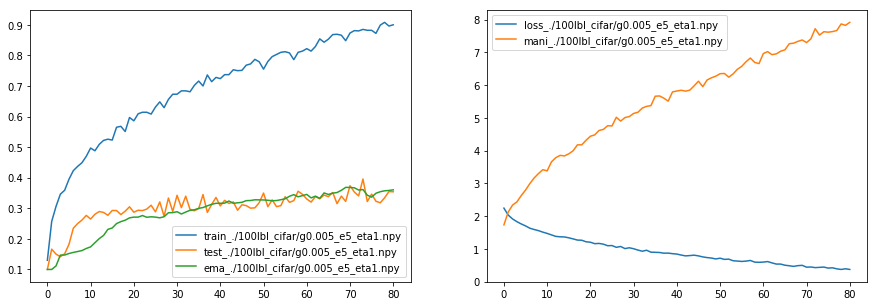

Epoch: 81,global_stp: 1640, xloss: 0.38742, maniloss: 7.78425, train: 89.90%, test: 35.17,test_ma: 35.93%
Epoch: 82,global_stp: 1660, xloss: 0.40567, maniloss: 7.88976, train: 89.30%, test: 34.62,test_ma: 36.23%
Epoch: 83,global_stp: 1680, xloss: 0.35865, maniloss: 7.89529, train: 89.90%, test: 34.52,test_ma: 37.72%
Epoch: 84,global_stp: 1700, xloss: 0.36511, maniloss: 8.09868, train: 89.70%, test: 38.73,test_ma: 36.93%
Epoch: 85,global_stp: 1720, xloss: 0.35649, maniloss: 7.96618, train: 91.10%, test: 35.72,test_ma: 36.52%
Epoch: 86,global_stp: 1740, xloss: 0.34209, maniloss: 8.10026, train: 92.60%, test: 31.86,test_ma: 36.71%
Epoch: 87,global_stp: 1760, xloss: 0.33198, maniloss: 8.25624, train: 91.60%, test: 38.84,test_ma: 37.42%
Epoch: 88,global_stp: 1780, xloss: 0.29127, maniloss: 8.03250, train: 93.70%, test: 36.40,test_ma: 36.30%
Epoch: 89,global_stp: 1800, xloss: 0.32104, maniloss: 8.02645, train: 91.60%, test: 33.85,test_ma: 36.73%
Epoch: 90,global_stp: 1820, xloss: 0.33331, ma

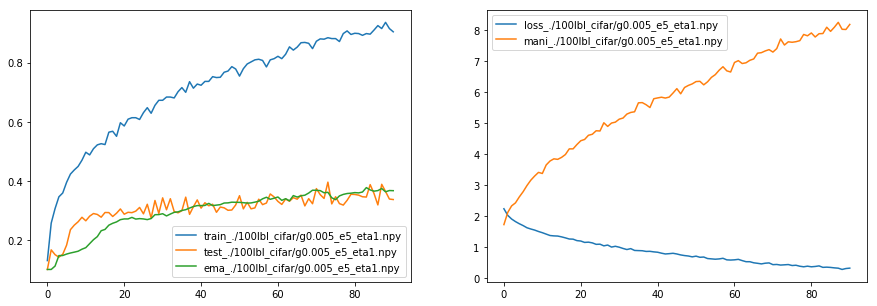

Epoch: 91,global_stp: 1840, xloss: 0.29814, maniloss: 8.36418, train: 92.90%, test: 39.12,test_ma: 37.41%
Epoch: 92,global_stp: 1860, xloss: 0.28980, maniloss: 8.31598, train: 93.10%, test: 34.12,test_ma: 36.34%
Epoch: 93,global_stp: 1880, xloss: 0.29083, maniloss: 8.41008, train: 93.00%, test: 35.38,test_ma: 37.64%
Epoch: 94,global_stp: 1900, xloss: 0.29669, maniloss: 8.30253, train: 92.80%, test: 35.58,test_ma: 37.67%
Epoch: 95,global_stp: 1920, xloss: 0.30943, maniloss: 8.49447, train: 92.80%, test: 35.51,test_ma: 37.96%
Epoch: 96,global_stp: 1940, xloss: 0.27538, maniloss: 8.47583, train: 93.70%, test: 41.36,test_ma: 38.53%
Epoch: 97,global_stp: 1960, xloss: 0.24202, maniloss: 8.63406, train: 93.90%, test: 37.18,test_ma: 37.58%
Epoch: 98,global_stp: 1980, xloss: 0.25772, maniloss: 8.52760, train: 94.20%, test: 41.42,test_ma: 36.72%
Epoch: 99,global_stp: 2000, xloss: 0.28620, maniloss: 8.57981, train: 91.30%, test: 34.21,test_ma: 36.92%
Epoch: 100,global_stp: 2020, xloss: 0.23501, m

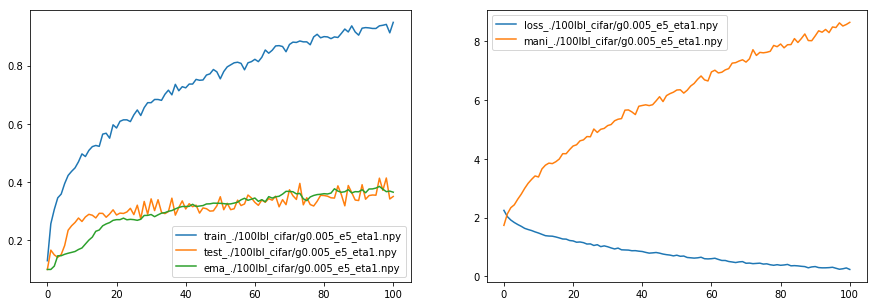

Epoch: 101,global_stp: 2040, xloss: 0.25517, maniloss: 8.65673, train: 93.70%, test: 34.91,test_ma: 37.42%
Epoch: 102,global_stp: 2060, xloss: 0.25742, maniloss: 8.51448, train: 94.30%, test: 38.39,test_ma: 37.90%
Epoch: 103,global_stp: 2080, xloss: 0.24209, maniloss: 8.60515, train: 93.80%, test: 36.42,test_ma: 37.48%
Epoch: 104,global_stp: 2100, xloss: 0.24386, maniloss: 8.72514, train: 94.00%, test: 33.32,test_ma: 37.70%
Epoch: 105,global_stp: 2120, xloss: 0.21964, maniloss: 8.79756, train: 95.40%, test: 35.78,test_ma: 39.48%
Epoch: 106,global_stp: 2140, xloss: 0.22353, maniloss: 8.65757, train: 95.10%, test: 36.51,test_ma: 38.81%
Epoch: 107,global_stp: 2160, xloss: 0.19604, maniloss: 8.80390, train: 96.90%, test: 41.20,test_ma: 38.70%
Epoch: 108,global_stp: 2180, xloss: 0.19907, maniloss: 8.77912, train: 96.20%, test: 36.87,test_ma: 38.09%
Epoch: 109,global_stp: 2200, xloss: 0.19205, maniloss: 9.01215, train: 96.10%, test: 34.44,test_ma: 37.72%
Epoch: 110,global_stp: 2220, xloss: 0

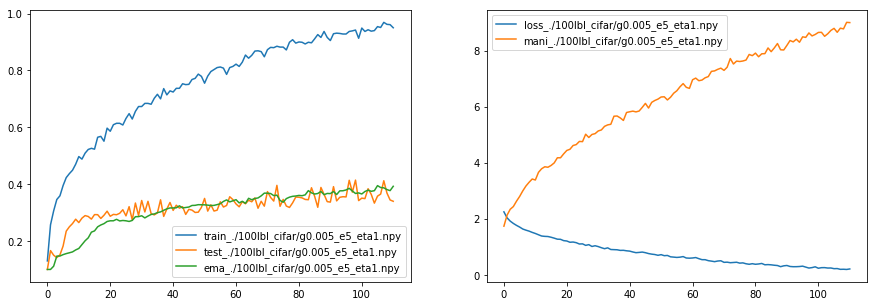

Epoch: 111,global_stp: 2240, xloss: 0.20087, maniloss: 9.00510, train: 95.80%, test: 38.29,test_ma: 38.13%
Epoch: 112,global_stp: 2260, xloss: 0.19957, maniloss: 9.16909, train: 95.80%, test: 36.62,test_ma: 38.66%
Epoch: 113,global_stp: 2280, xloss: 0.21305, maniloss: 9.08227, train: 94.30%, test: 37.94,test_ma: 39.59%
Epoch: 114,global_stp: 2300, xloss: 0.21388, maniloss: 8.90437, train: 95.10%, test: 38.67,test_ma: 39.48%
Epoch: 115,global_stp: 2320, xloss: 0.21453, maniloss: 9.08469, train: 94.30%, test: 35.03,test_ma: 40.47%
Epoch: 116,global_stp: 2340, xloss: 0.17743, maniloss: 9.20103, train: 96.30%, test: 41.63,test_ma: 40.35%
Epoch: 117,global_stp: 2360, xloss: 0.16303, maniloss: 8.98688, train: 96.80%, test: 38.72,test_ma: 39.64%
Epoch: 118,global_stp: 2380, xloss: 0.17141, maniloss: 9.08142, train: 96.90%, test: 40.50,test_ma: 38.69%
Epoch: 119,global_stp: 2400, xloss: 0.17185, maniloss: 8.88224, train: 96.40%, test: 39.17,test_ma: 38.55%
Epoch: 120,global_stp: 2420, xloss: 0

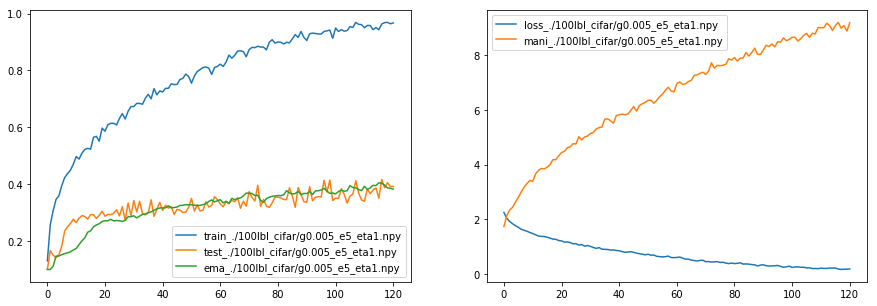

Epoch: 121,global_stp: 2440, xloss: 0.15799, maniloss: 9.26596, train: 96.60%, test: 40.56,test_ma: 38.24%
Epoch: 122,global_stp: 2460, xloss: 0.16313, maniloss: 9.24304, train: 96.40%, test: 35.67,test_ma: 38.56%
Epoch: 123,global_stp: 2480, xloss: 0.15206, maniloss: 9.28112, train: 97.60%, test: 37.04,test_ma: 39.41%
Epoch: 124,global_stp: 2500, xloss: 0.15440, maniloss: 9.26229, train: 96.40%, test: 37.49,test_ma: 40.76%
Epoch: 125,global_stp: 2520, xloss: 0.15053, maniloss: 9.33903, train: 96.90%, test: 36.57,test_ma: 41.98%
Epoch: 126,global_stp: 2540, xloss: 0.12847, maniloss: 9.33911, train: 97.50%, test: 36.34,test_ma: 43.59%
Epoch: 127,global_stp: 2560, xloss: 0.14391, maniloss: 9.34392, train: 98.00%, test: 44.31,test_ma: 40.99%
Epoch: 128,global_stp: 2580, xloss: 0.11848, maniloss: 9.12215, train: 98.20%, test: 40.22,test_ma: 40.80%
Epoch: 129,global_stp: 2600, xloss: 0.16109, maniloss: 9.41861, train: 97.00%, test: 36.74,test_ma: 41.81%
Epoch: 130,global_stp: 2620, xloss: 0

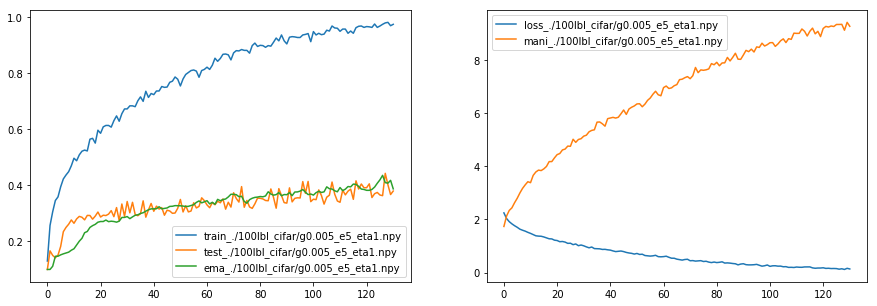

Epoch: 131,global_stp: 2640, xloss: 0.15490, maniloss: 9.29203, train: 96.80%, test: 37.20,test_ma: 39.16%
Epoch: 132,global_stp: 2660, xloss: 0.13232, maniloss: 9.47786, train: 97.50%, test: 40.04,test_ma: 38.57%
Epoch: 133,global_stp: 2680, xloss: 0.15467, maniloss: 9.27566, train: 96.80%, test: 37.82,test_ma: 37.41%
Epoch: 134,global_stp: 2700, xloss: 0.13191, maniloss: 9.30193, train: 97.90%, test: 36.59,test_ma: 39.18%
Epoch: 135,global_stp: 2720, xloss: 0.15009, maniloss: 9.47356, train: 95.70%, test: 41.59,test_ma: 38.53%
Epoch: 136,global_stp: 2740, xloss: 0.13021, maniloss: 9.39437, train: 97.40%, test: 40.34,test_ma: 38.27%
Epoch: 137,global_stp: 2760, xloss: 0.14274, maniloss: 9.63534, train: 96.90%, test: 40.28,test_ma: 39.30%
Epoch: 138,global_stp: 2780, xloss: 0.14411, maniloss: 9.53630, train: 96.80%, test: 40.59,test_ma: 39.14%
Epoch: 139,global_stp: 2800, xloss: 0.14108, maniloss: 9.55231, train: 96.90%, test: 40.35,test_ma: 40.59%
Epoch: 140,global_stp: 2820, xloss: 0

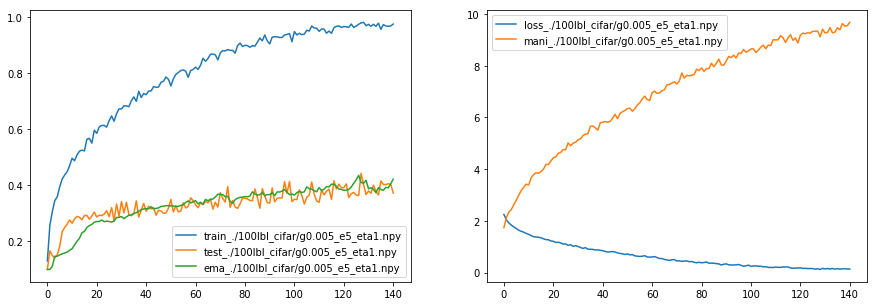

Epoch: 141,global_stp: 2840, xloss: 0.14272, maniloss: 9.59506, train: 97.20%, test: 43.67,test_ma: 41.14%
Epoch: 142,global_stp: 2860, xloss: 0.11007, maniloss: 9.63172, train: 98.20%, test: 38.01,test_ma: 40.33%
Epoch: 143,global_stp: 2880, xloss: 0.11694, maniloss: 9.55236, train: 98.00%, test: 37.10,test_ma: 41.84%
Epoch: 144,global_stp: 2900, xloss: 0.10904, maniloss: 9.61635, train: 97.50%, test: 38.35,test_ma: 42.44%
Epoch: 145,global_stp: 2920, xloss: 0.11206, maniloss: 9.60358, train: 98.20%, test: 42.25,test_ma: 42.10%
Epoch: 146,global_stp: 2940, xloss: 0.10855, maniloss: 9.51875, train: 97.80%, test: 39.24,test_ma: 39.35%
Epoch: 147,global_stp: 2960, xloss: 0.13515, maniloss: 9.56214, train: 96.80%, test: 39.86,test_ma: 40.60%
Epoch: 148,global_stp: 2980, xloss: 0.10789, maniloss: 9.70805, train: 98.20%, test: 37.81,test_ma: 40.54%
Epoch: 149,global_stp: 3000, xloss: 0.10129, maniloss: 9.71287, train: 98.60%, test: 40.43,test_ma: 41.89%
Epoch: 150,global_stp: 3020, xloss: 0

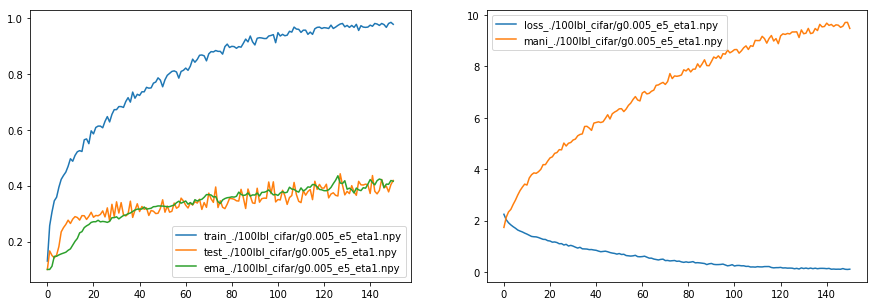

Epoch: 151,global_stp: 3040, xloss: 0.10631, maniloss: 9.73349, train: 98.10%, test: 42.77,test_ma: 41.84%
Epoch: 152,global_stp: 3060, xloss: 0.13495, maniloss: 9.69624, train: 96.40%, test: 40.02,test_ma: 41.19%
Epoch: 153,global_stp: 3080, xloss: 0.10681, maniloss: 9.81038, train: 97.70%, test: 40.45,test_ma: 41.50%
Epoch: 154,global_stp: 3100, xloss: 0.10311, maniloss: 9.83932, train: 98.10%, test: 40.34,test_ma: 42.46%
Epoch: 155,global_stp: 3120, xloss: 0.09922, maniloss: 9.66421, train: 98.50%, test: 42.42,test_ma: 41.96%
Epoch: 156,global_stp: 3140, xloss: 0.10011, maniloss: 9.73587, train: 97.70%, test: 39.16,test_ma: 41.50%
Epoch: 157,global_stp: 3160, xloss: 0.10183, maniloss: 9.82813, train: 97.70%, test: 41.43,test_ma: 42.96%
Epoch: 158,global_stp: 3180, xloss: 0.09482, maniloss: 9.67471, train: 98.70%, test: 42.46,test_ma: 41.87%
Epoch: 159,global_stp: 3200, xloss: 0.08564, maniloss: 9.70601, train: 98.80%, test: 39.13,test_ma: 42.27%
Epoch: 160,global_stp: 3220, xloss: 0

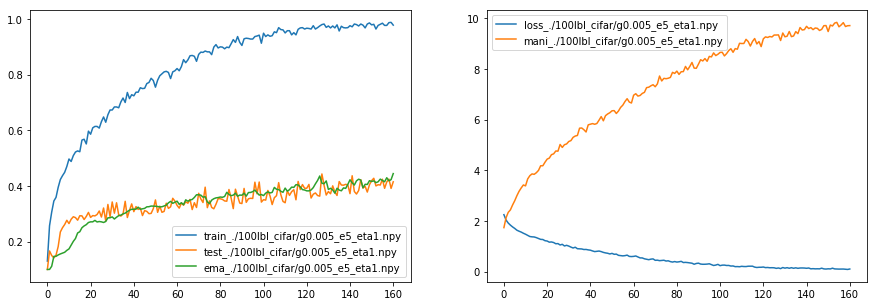

Epoch: 161,global_stp: 3240, xloss: 0.08189, maniloss: 9.84156, train: 99.00%, test: 45.71,test_ma: 42.68%
Epoch: 162,global_stp: 3260, xloss: 0.10256, maniloss: 9.69800, train: 97.70%, test: 39.18,test_ma: 43.87%
Epoch: 163,global_stp: 3280, xloss: 0.09539, maniloss: 9.83468, train: 98.60%, test: 40.39,test_ma: 43.70%
Epoch: 164,global_stp: 3300, xloss: 0.08495, maniloss: 9.86400, train: 99.00%, test: 40.89,test_ma: 44.50%
Epoch: 165,global_stp: 3320, xloss: 0.07601, maniloss: 9.87159, train: 99.00%, test: 43.45,test_ma: 43.28%
Epoch: 166,global_stp: 3340, xloss: 0.07070, maniloss: 9.88265, train: 99.30%, test: 42.09,test_ma: 42.41%
Epoch: 167,global_stp: 3360, xloss: 0.08089, maniloss: 9.98851, train: 98.70%, test: 42.35,test_ma: 43.46%
Epoch: 168,global_stp: 3380, xloss: 0.08218, maniloss: 9.88116, train: 98.40%, test: 43.35,test_ma: 42.28%
Epoch: 169,global_stp: 3400, xloss: 0.07427, maniloss: 9.97481, train: 99.00%, test: 41.15,test_ma: 43.83%
Epoch: 170,global_stp: 3420, xloss: 0

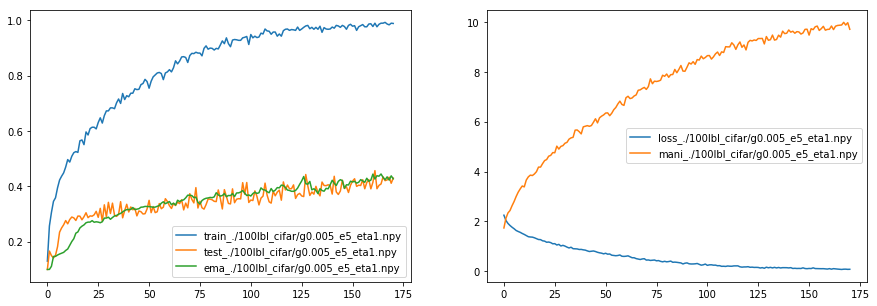

Epoch: 171,global_stp: 3440, xloss: 0.08651, maniloss: 9.95900, train: 98.40%, test: 41.57,test_ma: 44.02%
Epoch: 172,global_stp: 3460, xloss: 0.07025, maniloss: 10.08448, train: 99.20%, test: 39.07,test_ma: 43.82%
Epoch: 173,global_stp: 3480, xloss: 0.07631, maniloss: 9.98550, train: 98.80%, test: 43.91,test_ma: 43.57%
Epoch: 174,global_stp: 3500, xloss: 0.07667, maniloss: 9.68418, train: 98.50%, test: 38.48,test_ma: 43.24%
Epoch: 175,global_stp: 3520, xloss: 0.07167, maniloss: 9.91144, train: 99.40%, test: 43.41,test_ma: 43.86%
Epoch: 176,global_stp: 3540, xloss: 0.09914, maniloss: 9.90355, train: 97.70%, test: 41.35,test_ma: 43.83%
Epoch: 177,global_stp: 3560, xloss: 0.08433, maniloss: 10.10330, train: 98.30%, test: 45.62,test_ma: 43.41%
Epoch: 178,global_stp: 3580, xloss: 0.10123, maniloss: 9.95251, train: 98.00%, test: 39.77,test_ma: 43.85%
Epoch: 179,global_stp: 3600, xloss: 0.09375, maniloss: 10.00649, train: 97.80%, test: 43.60,test_ma: 41.86%
Epoch: 180,global_stp: 3620, xloss

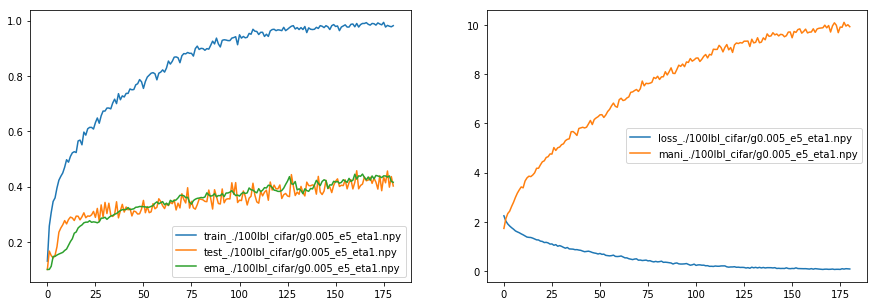

Epoch: 181,global_stp: 3640, xloss: 0.08444, maniloss: 9.88857, train: 98.20%, test: 40.74,test_ma: 42.80%
Epoch: 182,global_stp: 3660, xloss: 0.07973, maniloss: 9.59221, train: 98.60%, test: 37.80,test_ma: 43.44%
Epoch: 183,global_stp: 3680, xloss: 0.08256, maniloss: 10.12122, train: 98.10%, test: 44.05,test_ma: 44.93%
Epoch: 184,global_stp: 3700, xloss: 0.06583, maniloss: 9.83300, train: 99.00%, test: 42.73,test_ma: 46.44%
Epoch: 185,global_stp: 3720, xloss: 0.07951, maniloss: 9.96251, train: 98.60%, test: 46.15,test_ma: 44.95%
Epoch: 186,global_stp: 3740, xloss: 0.07219, maniloss: 9.89228, train: 98.70%, test: 40.79,test_ma: 41.98%
Epoch: 187,global_stp: 3760, xloss: 0.08650, maniloss: 10.25850, train: 98.60%, test: 41.34,test_ma: 42.24%
Epoch: 188,global_stp: 3780, xloss: 0.06469, maniloss: 10.03203, train: 98.90%, test: 42.16,test_ma: 42.42%
Epoch: 189,global_stp: 3800, xloss: 0.05661, maniloss: 10.16279, train: 99.10%, test: 40.53,test_ma: 42.96%
Epoch: 190,global_stp: 3820, xlos

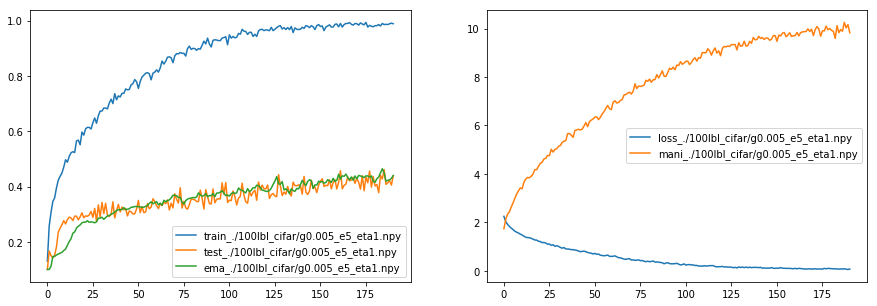

Epoch: 191,global_stp: 3840, xloss: 0.06786, maniloss: 9.90618, train: 98.50%, test: 41.85,test_ma: 44.02%
Epoch: 192,global_stp: 3860, xloss: 0.07409, maniloss: 10.02651, train: 98.50%, test: 39.91,test_ma: 43.06%
Epoch: 193,global_stp: 3880, xloss: 0.07811, maniloss: 9.99964, train: 98.50%, test: 43.10,test_ma: 43.99%
Epoch: 194,global_stp: 3900, xloss: 0.06866, maniloss: 10.06424, train: 99.10%, test: 42.08,test_ma: 43.03%
Epoch: 195,global_stp: 3920, xloss: 0.07357, maniloss: 10.06305, train: 98.70%, test: 41.95,test_ma: 44.50%
Epoch: 196,global_stp: 3940, xloss: 0.07994, maniloss: 10.01315, train: 98.10%, test: 44.18,test_ma: 44.56%
Epoch: 197,global_stp: 3960, xloss: 0.07035, maniloss: 10.05922, train: 98.70%, test: 44.08,test_ma: 45.63%
Epoch: 198,global_stp: 3980, xloss: 0.06329, maniloss: 10.09845, train: 98.90%, test: 45.02,test_ma: 44.89%
Epoch: 199,global_stp: 4000, xloss: 0.05860, maniloss: 10.18617, train: 99.40%, test: 43.81,test_ma: 44.26%
Epoch: 200,global_stp: 4020, x

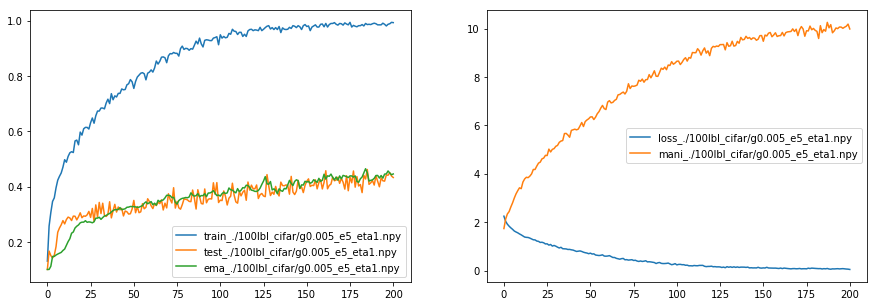

Epoch: 201,global_stp: 4040, xloss: 0.05492, maniloss: 9.95974, train: 99.10%, test: 44.18,test_ma: 44.67%
Epoch: 202,global_stp: 4060, xloss: 0.05307, maniloss: 10.01986, train: 99.20%, test: 47.54,test_ma: 45.01%
Epoch: 203,global_stp: 4080, xloss: 0.05579, maniloss: 10.18391, train: 98.80%, test: 44.76,test_ma: 43.82%
Epoch: 204,global_stp: 4100, xloss: 0.04117, maniloss: 9.90487, train: 99.70%, test: 44.61,test_ma: 44.05%
Epoch: 205,global_stp: 4120, xloss: 0.04729, maniloss: 10.05236, train: 99.50%, test: 43.34,test_ma: 43.43%
Epoch: 206,global_stp: 4140, xloss: 0.04464, maniloss: 9.95829, train: 99.70%, test: 43.90,test_ma: 44.26%
Epoch: 207,global_stp: 4160, xloss: 0.04353, maniloss: 10.00397, train: 99.80%, test: 43.44,test_ma: 45.21%
Epoch: 208,global_stp: 4180, xloss: 0.04481, maniloss: 10.11960, train: 99.50%, test: 47.11,test_ma: 45.16%
Epoch: 209,global_stp: 4200, xloss: 0.04607, maniloss: 10.06106, train: 99.30%, test: 45.20,test_ma: 43.18%
Epoch: 210,global_stp: 4220, xl

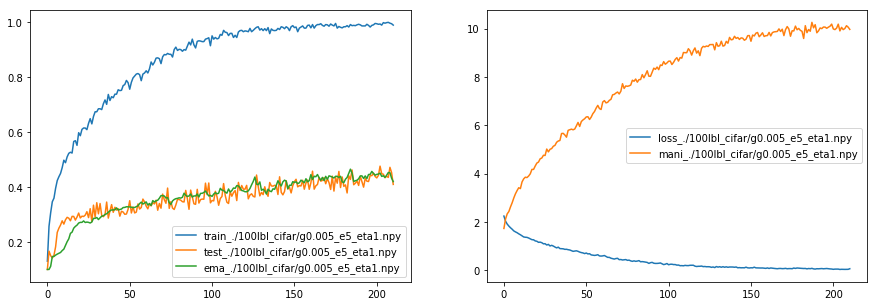

Epoch: 211,global_stp: 4240, xloss: 0.07043, maniloss: 9.97577, train: 98.80%, test: 44.60,test_ma: 41.64%
Epoch: 212,global_stp: 4260, xloss: 0.06317, maniloss: 10.09718, train: 99.00%, test: 44.61,test_ma: 42.90%
Epoch: 213,global_stp: 4280, xloss: 0.07676, maniloss: 9.92387, train: 98.10%, test: 42.08,test_ma: 42.75%
Epoch: 214,global_stp: 4300, xloss: 0.06095, maniloss: 9.98535, train: 98.70%, test: 41.82,test_ma: 43.71%
Epoch: 215,global_stp: 4320, xloss: 0.06145, maniloss: 9.99835, train: 98.90%, test: 40.41,test_ma: 44.74%
Epoch: 216,global_stp: 4340, xloss: 0.05613, maniloss: 10.13739, train: 99.10%, test: 45.20,test_ma: 46.02%
Epoch: 217,global_stp: 4360, xloss: 0.05369, maniloss: 10.06687, train: 99.20%, test: 45.18,test_ma: 45.10%
Epoch: 218,global_stp: 4380, xloss: 0.07071, maniloss: 10.27232, train: 98.30%, test: 44.69,test_ma: 46.86%
Epoch: 219,global_stp: 4400, xloss: 0.07498, maniloss: 9.80324, train: 98.50%, test: 45.56,test_ma: 45.48%
Epoch: 220,global_stp: 4420, xlos

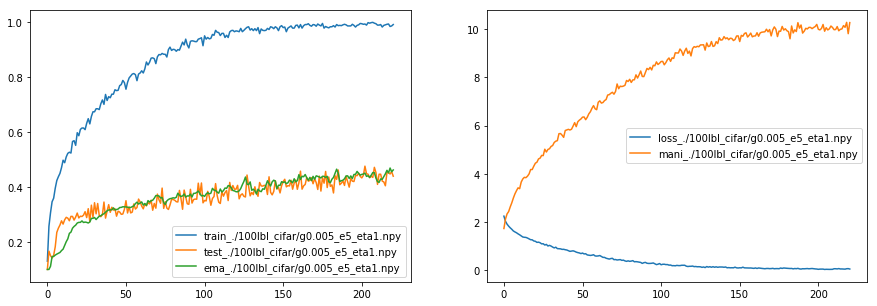

Epoch: 221,global_stp: 4440, xloss: 0.07344, maniloss: 10.12335, train: 98.50%, test: 45.12,test_ma: 46.97%
Epoch: 222,global_stp: 4460, xloss: 0.07070, maniloss: 10.05242, train: 98.80%, test: 40.81,test_ma: 46.12%
Epoch: 223,global_stp: 4480, xloss: 0.05933, maniloss: 10.23254, train: 99.10%, test: 47.28,test_ma: 47.45%
Epoch: 224,global_stp: 4500, xloss: 0.06124, maniloss: 10.07216, train: 98.70%, test: 43.34,test_ma: 45.68%
Epoch: 225,global_stp: 4520, xloss: 0.06365, maniloss: 10.06513, train: 98.90%, test: 48.17,test_ma: 44.41%
Epoch: 226,global_stp: 4540, xloss: 0.06737, maniloss: 10.10638, train: 98.30%, test: 38.32,test_ma: 45.04%
Epoch: 227,global_stp: 4560, xloss: 0.07246, maniloss: 9.91334, train: 98.80%, test: 45.92,test_ma: 44.92%
Epoch: 228,global_stp: 4580, xloss: 0.05428, maniloss: 10.05117, train: 98.90%, test: 41.20,test_ma: 46.88%
Epoch: 229,global_stp: 4600, xloss: 0.04391, maniloss: 9.93096, train: 99.30%, test: 47.42,test_ma: 45.93%
Epoch: 230,global_stp: 4620, x

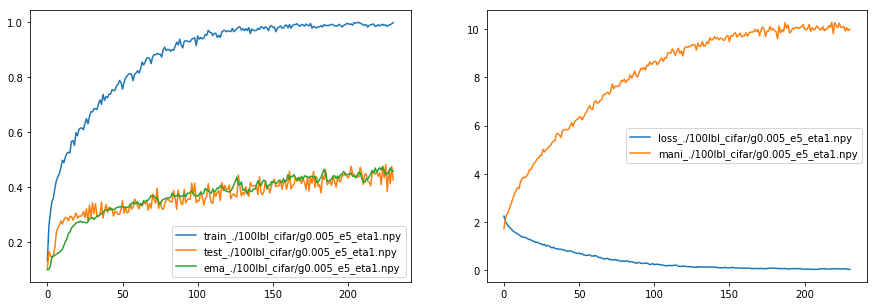

Epoch: 231,global_stp: 4640, xloss: 0.04255, maniloss: 10.20703, train: 99.60%, test: 48.08,test_ma: 45.41%
Epoch: 232,global_stp: 4660, xloss: 0.04090, maniloss: 10.15725, train: 99.50%, test: 42.20,test_ma: 44.66%
Epoch: 233,global_stp: 4680, xloss: 0.03965, maniloss: 10.04875, train: 99.60%, test: 46.59,test_ma: 46.39%
Epoch: 234,global_stp: 4700, xloss: 0.04526, maniloss: 10.12658, train: 99.30%, test: 46.41,test_ma: 46.22%
Epoch: 235,global_stp: 4720, xloss: 0.04758, maniloss: 9.98572, train: 99.10%, test: 44.88,test_ma: 45.71%
Epoch: 236,global_stp: 4740, xloss: 0.03959, maniloss: 10.17154, train: 99.70%, test: 48.30,test_ma: 45.76%
Epoch: 237,global_stp: 4760, xloss: 0.03171, maniloss: 9.95386, train: 99.50%, test: 46.86,test_ma: 45.34%
Epoch: 238,global_stp: 4780, xloss: 0.03608, maniloss: 9.93290, train: 99.70%, test: 45.41,test_ma: 46.06%
Epoch: 239,global_stp: 4800, xloss: 0.03204, maniloss: 9.99884, train: 99.70%, test: 43.85,test_ma: 47.24%
Epoch: 240,global_stp: 4820, xlo

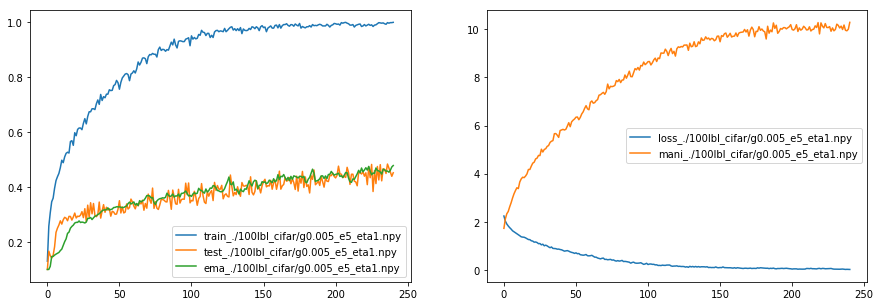

Epoch: 241,global_stp: 4840, xloss: 0.04521, maniloss: 9.94312, train: 99.00%, test: 46.23,test_ma: 49.02%
Epoch: 242,global_stp: 4860, xloss: 0.05771, maniloss: 10.10538, train: 99.20%, test: 43.37,test_ma: 45.74%
Epoch: 243,global_stp: 4880, xloss: 0.03920, maniloss: 10.13227, train: 99.70%, test: 46.39,test_ma: 47.76%
Epoch: 244,global_stp: 4900, xloss: 0.04586, maniloss: 10.09370, train: 99.00%, test: 45.30,test_ma: 47.03%
Epoch: 245,global_stp: 4920, xloss: 0.05194, maniloss: 10.16424, train: 98.90%, test: 45.99,test_ma: 46.16%
Epoch: 246,global_stp: 4940, xloss: 0.04673, maniloss: 9.98699, train: 99.50%, test: 44.79,test_ma: 47.66%
Epoch: 247,global_stp: 4960, xloss: 0.05593, maniloss: 10.03129, train: 98.80%, test: 45.40,test_ma: 47.25%
Epoch: 248,global_stp: 4980, xloss: 0.05013, maniloss: 9.99368, train: 99.20%, test: 46.38,test_ma: 44.99%
Epoch: 249,global_stp: 5000, xloss: 0.04622, maniloss: 10.06272, train: 99.20%, test: 43.86,test_ma: 45.78%
Epoch: 250,global_stp: 5020, xl

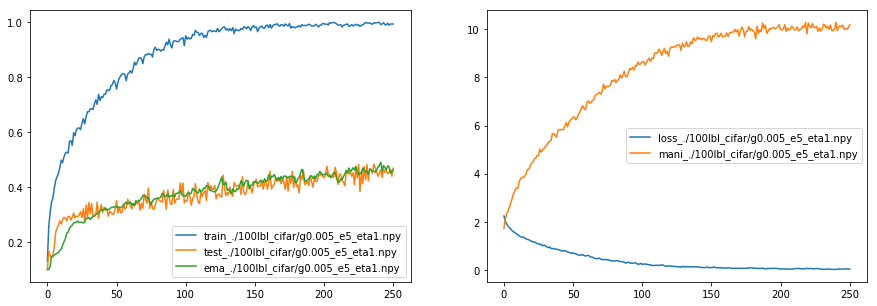

Epoch: 251,global_stp: 5040, xloss: 0.04394, maniloss: 9.96976, train: 99.30%, test: 47.69,test_ma: 43.95%
Epoch: 252,global_stp: 5060, xloss: 0.04575, maniloss: 10.04019, train: 99.20%, test: 45.44,test_ma: 43.51%
Epoch: 253,global_stp: 5080, xloss: 0.03942, maniloss: 10.16988, train: 99.60%, test: 47.53,test_ma: 44.13%
Epoch: 254,global_stp: 5100, xloss: 0.04054, maniloss: 10.08616, train: 99.40%, test: 44.10,test_ma: 45.48%
Epoch: 255,global_stp: 5120, xloss: 0.04762, maniloss: 9.91244, train: 99.40%, test: 41.44,test_ma: 45.99%
Epoch: 256,global_stp: 5140, xloss: 0.04124, maniloss: 10.13359, train: 99.40%, test: 46.12,test_ma: 47.81%
Epoch: 257,global_stp: 5160, xloss: 0.03701, maniloss: 10.17512, train: 99.80%, test: 45.22,test_ma: 47.50%
Epoch: 258,global_stp: 5180, xloss: 0.04477, maniloss: 9.95709, train: 99.10%, test: 46.07,test_ma: 48.94%
Epoch: 259,global_stp: 5200, xloss: 0.05088, maniloss: 9.98921, train: 98.90%, test: 44.22,test_ma: 49.73%
Epoch: 260,global_stp: 5220, xlo

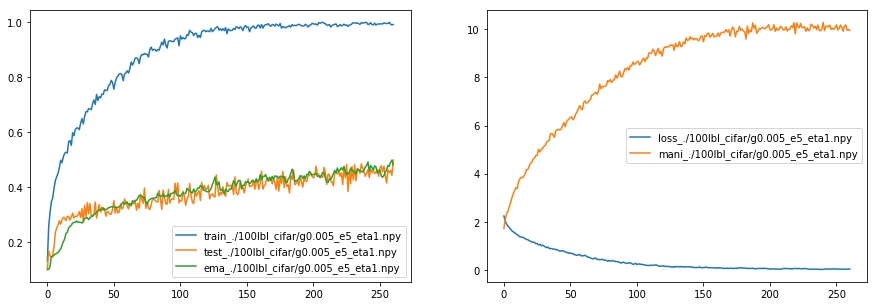

Epoch: 261,global_stp: 5240, xloss: 0.05147, maniloss: 9.89789, train: 98.80%, test: 47.05,test_ma: 47.39%
Epoch: 262,global_stp: 5260, xloss: 0.03688, maniloss: 9.96769, train: 99.60%, test: 46.39,test_ma: 47.25%
Epoch: 263,global_stp: 5280, xloss: 0.03833, maniloss: 9.92038, train: 99.80%, test: 44.09,test_ma: 46.78%
Epoch: 264,global_stp: 5300, xloss: 0.03215, maniloss: 10.08580, train: 99.70%, test: 45.64,test_ma: 48.32%
Epoch: 265,global_stp: 5320, xloss: 0.02727, maniloss: 10.03185, train: 99.60%, test: 47.12,test_ma: 47.65%
Epoch: 266,global_stp: 5340, xloss: 0.06040, maniloss: 9.96472, train: 98.40%, test: 43.20,test_ma: 49.39%
Epoch: 267,global_stp: 5360, xloss: 0.03902, maniloss: 9.87941, train: 99.30%, test: 46.67,test_ma: 48.82%
Epoch: 268,global_stp: 5380, xloss: 0.04040, maniloss: 9.92443, train: 99.40%, test: 47.20,test_ma: 46.93%
Epoch: 269,global_stp: 5400, xloss: 0.04488, maniloss: 10.01307, train: 99.00%, test: 42.75,test_ma: 49.31%
Epoch: 270,global_stp: 5420, xloss

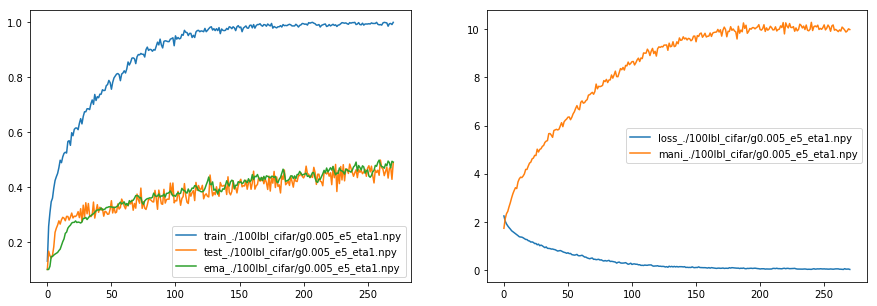

Epoch: 271,global_stp: 5440, xloss: 0.02539, maniloss: 10.24425, train: 99.60%, test: 46.73,test_ma: 47.91%
Epoch: 272,global_stp: 5460, xloss: 0.02896, maniloss: 10.21898, train: 99.40%, test: 44.91,test_ma: 48.33%
Epoch: 273,global_stp: 5480, xloss: 0.04041, maniloss: 9.96528, train: 99.40%, test: 46.88,test_ma: 48.00%
Epoch: 274,global_stp: 5500, xloss: 0.03804, maniloss: 9.91871, train: 99.30%, test: 48.16,test_ma: 46.86%
Epoch: 275,global_stp: 5520, xloss: 0.03967, maniloss: 10.03284, train: 99.40%, test: 47.23,test_ma: 44.01%
Epoch: 276,global_stp: 5540, xloss: 0.03849, maniloss: 9.89284, train: 99.60%, test: 40.02,test_ma: 46.81%
Epoch: 277,global_stp: 5560, xloss: 0.05018, maniloss: 10.11591, train: 99.00%, test: 49.56,test_ma: 47.99%
Epoch: 278,global_stp: 5580, xloss: 0.02857, maniloss: 9.99711, train: 99.50%, test: 46.10,test_ma: 48.34%
Epoch: 279,global_stp: 5600, xloss: 0.03970, maniloss: 10.04501, train: 99.30%, test: 46.52,test_ma: 48.70%
Epoch: 280,global_stp: 5620, xlo

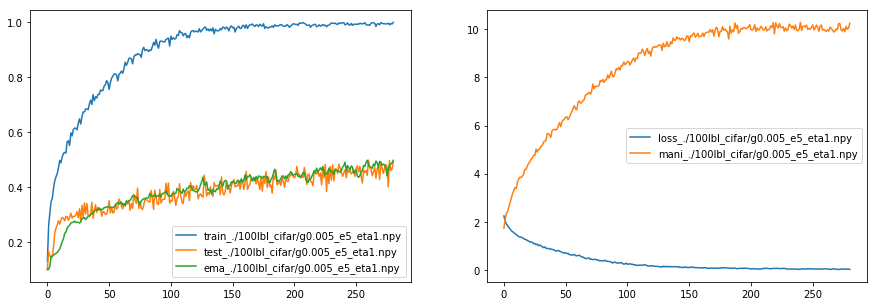

Epoch: 281,global_stp: 5640, xloss: 0.04116, maniloss: 9.92677, train: 99.20%, test: 50.59,test_ma: 48.51%
Epoch: 282,global_stp: 5660, xloss: 0.03966, maniloss: 9.90062, train: 99.40%, test: 45.04,test_ma: 47.51%
Epoch: 283,global_stp: 5680, xloss: 0.03923, maniloss: 9.81973, train: 99.70%, test: 49.55,test_ma: 46.34%
Epoch: 284,global_stp: 5700, xloss: 0.03233, maniloss: 10.22695, train: 99.70%, test: 45.37,test_ma: 46.19%
Epoch: 285,global_stp: 5720, xloss: 0.02700, maniloss: 9.79742, train: 99.80%, test: 49.95,test_ma: 46.19%
Epoch: 286,global_stp: 5740, xloss: 0.02034, maniloss: 9.71305, train: 99.90%, test: 46.35,test_ma: 46.88%
Epoch: 287,global_stp: 5760, xloss: 0.02680, maniloss: 9.96392, train: 99.60%, test: 48.45,test_ma: 47.77%
Epoch: 288,global_stp: 5780, xloss: 0.02638, maniloss: 10.03135, train: 99.80%, test: 48.51,test_ma: 48.48%
Epoch: 289,global_stp: 5800, xloss: 0.04086, maniloss: 9.65591, train: 99.20%, test: 46.57,test_ma: 49.11%
Epoch: 290,global_stp: 5820, xloss:

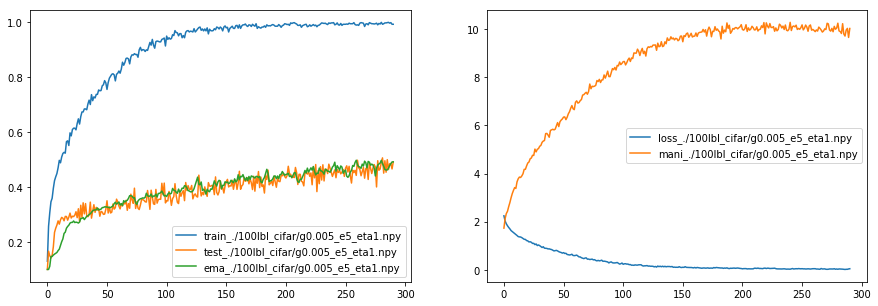

Epoch: 291,global_stp: 5840, xloss: 0.03768, maniloss: 9.99888, train: 99.30%, test: 48.30,test_ma: 47.37%
Epoch: 292,global_stp: 5860, xloss: 0.04021, maniloss: 9.94831, train: 99.30%, test: 45.24,test_ma: 48.20%
Epoch: 293,global_stp: 5880, xloss: 0.03408, maniloss: 9.96133, train: 99.60%, test: 46.66,test_ma: 50.57%
Epoch: 294,global_stp: 5900, xloss: 0.02786, maniloss: 10.25675, train: 99.70%, test: 49.17,test_ma: 50.14%
Epoch: 295,global_stp: 5920, xloss: 0.02541, maniloss: 10.01900, train: 99.60%, test: 48.03,test_ma: 49.89%
Epoch: 296,global_stp: 5940, xloss: 0.03448, maniloss: 10.09337, train: 99.60%, test: 47.53,test_ma: 50.49%
Epoch: 297,global_stp: 5960, xloss: 0.03500, maniloss: 9.81853, train: 99.40%, test: 47.91,test_ma: 50.01%
Epoch: 298,global_stp: 5980, xloss: 0.03410, maniloss: 9.93965, train: 99.20%, test: 48.12,test_ma: 49.18%
Epoch: 299,global_stp: 6000, xloss: 0.03336, maniloss: 9.83322, train: 99.50%, test: 50.12,test_ma: 48.95%
Epoch: 300,global_stp: 6020, xloss

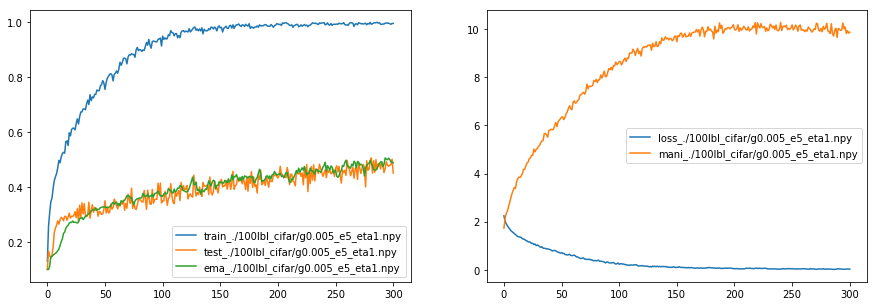

Epoch: 301,global_stp: 6040, xloss: 0.03584, maniloss: 9.81709, train: 99.20%, test: 46.14,test_ma: 49.69%
Epoch: 302,global_stp: 6060, xloss: 0.04063, maniloss: 9.95445, train: 99.00%, test: 48.72,test_ma: 49.36%
Epoch: 303,global_stp: 6080, xloss: 0.03698, maniloss: 9.95490, train: 99.50%, test: 50.58,test_ma: 48.56%
Epoch: 304,global_stp: 6100, xloss: 0.05876, maniloss: 9.91033, train: 98.30%, test: 40.90,test_ma: 49.39%
Epoch: 305,global_stp: 6120, xloss: 0.07646, maniloss: 9.69763, train: 97.50%, test: 46.23,test_ma: 49.88%
Epoch: 306,global_stp: 6140, xloss: 0.04655, maniloss: 9.89523, train: 99.20%, test: 47.51,test_ma: 49.66%
Epoch: 307,global_stp: 6160, xloss: 0.03886, maniloss: 9.94803, train: 99.30%, test: 45.63,test_ma: 47.84%
Epoch: 308,global_stp: 6180, xloss: 0.04720, maniloss: 9.80016, train: 99.10%, test: 50.40,test_ma: 47.66%
Epoch: 309,global_stp: 6200, xloss: 0.04466, maniloss: 9.79587, train: 99.20%, test: 48.10,test_ma: 45.66%
Epoch: 310,global_stp: 6220, xloss: 0

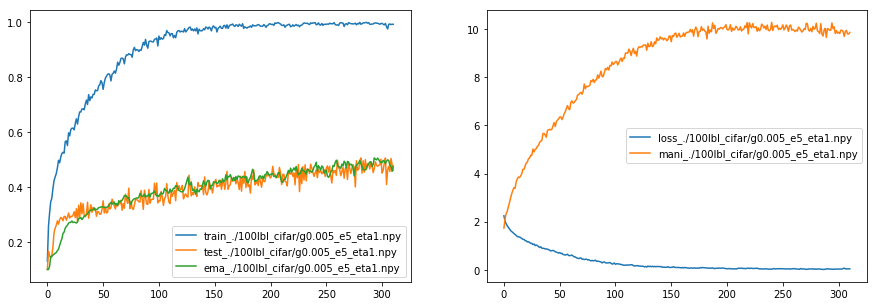

Epoch: 311,global_stp: 6240, xloss: 0.05411, maniloss: 9.80533, train: 98.60%, test: 46.12,test_ma: 47.35%
Epoch: 312,global_stp: 6260, xloss: 0.05360, maniloss: 9.85609, train: 98.90%, test: 44.69,test_ma: 47.45%
Epoch: 313,global_stp: 6280, xloss: 0.04854, maniloss: 9.78420, train: 98.90%, test: 47.45,test_ma: 48.72%
Epoch: 314,global_stp: 6300, xloss: 0.05303, maniloss: 9.71248, train: 98.90%, test: 49.54,test_ma: 48.29%
Epoch: 315,global_stp: 6320, xloss: 0.04136, maniloss: 9.90528, train: 99.30%, test: 46.62,test_ma: 47.63%
Epoch: 316,global_stp: 6340, xloss: 0.04757, maniloss: 9.89077, train: 99.00%, test: 47.68,test_ma: 49.70%
Epoch: 317,global_stp: 6360, xloss: 0.02871, maniloss: 9.91139, train: 99.70%, test: 48.98,test_ma: 47.22%
Epoch: 318,global_stp: 6380, xloss: 0.03337, maniloss: 9.89474, train: 99.50%, test: 46.45,test_ma: 49.16%
Epoch: 319,global_stp: 6400, xloss: 0.03223, maniloss: 9.97554, train: 99.80%, test: 45.73,test_ma: 49.19%
Epoch: 320,global_stp: 6420, xloss: 0

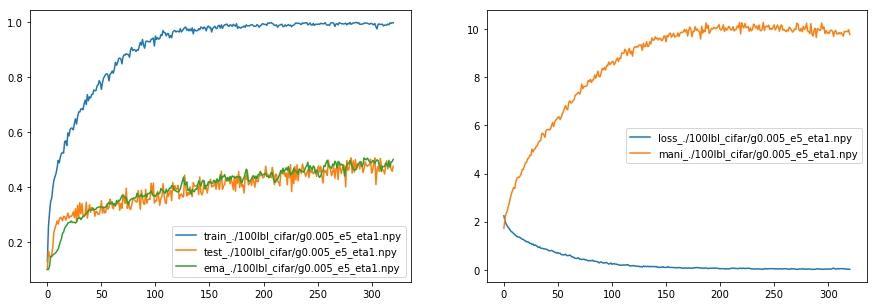

Epoch: 321,global_stp: 6440, xloss: 0.03142, maniloss: 9.78316, train: 99.40%, test: 49.84,test_ma: 50.17%
Epoch: 322,global_stp: 6460, xloss: 0.02880, maniloss: 9.94608, train: 99.60%, test: 45.82,test_ma: 46.98%
Epoch: 323,global_stp: 6480, xloss: 0.02095, maniloss: 9.89078, train: 99.80%, test: 46.95,test_ma: 49.36%
Epoch: 324,global_stp: 6500, xloss: 0.02355, maniloss: 10.00087, train: 99.70%, test: 50.05,test_ma: 48.60%
Epoch: 325,global_stp: 6520, xloss: 0.01945, maniloss: 9.98717, train: 99.70%, test: 45.84,test_ma: 50.29%
Epoch: 326,global_stp: 6540, xloss: 0.02028, maniloss: 9.96493, train: 99.90%, test: 49.92,test_ma: 50.68%
Epoch: 327,global_stp: 6560, xloss: 0.02295, maniloss: 9.90880, train: 99.60%, test: 49.52,test_ma: 49.73%
Epoch: 328,global_stp: 6580, xloss: 0.02832, maniloss: 9.82555, train: 99.50%, test: 49.69,test_ma: 48.55%
Epoch: 329,global_stp: 6600, xloss: 0.03476, maniloss: 9.69592, train: 99.20%, test: 46.01,test_ma: 47.66%
Epoch: 330,global_stp: 6620, xloss: 

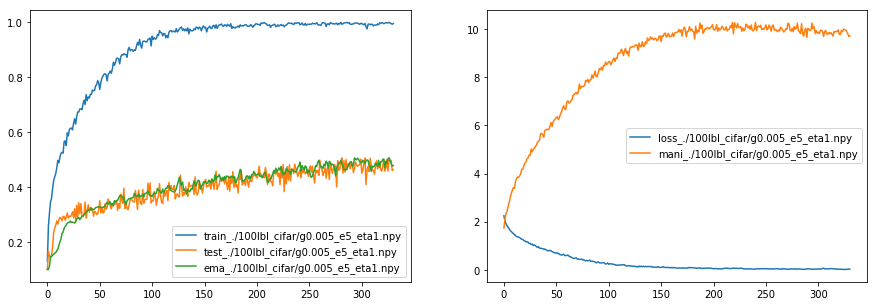

Epoch: 331,global_stp: 6640, xloss: 0.02569, maniloss: 9.72635, train: 99.60%, test: 50.85,test_ma: 49.44%
Epoch: 332,global_stp: 6660, xloss: 0.02092, maniloss: 9.91345, train: 99.80%, test: 48.26,test_ma: 49.13%
Epoch: 333,global_stp: 6680, xloss: 0.02743, maniloss: 9.83361, train: 99.60%, test: 47.16,test_ma: 49.33%
Epoch: 334,global_stp: 6700, xloss: 0.02403, maniloss: 9.73906, train: 99.80%, test: 49.69,test_ma: 50.57%
Epoch: 335,global_stp: 6720, xloss: 0.03013, maniloss: 9.72253, train: 99.60%, test: 51.55,test_ma: 49.53%
Epoch: 336,global_stp: 6740, xloss: 0.03540, maniloss: 9.68057, train: 99.60%, test: 47.53,test_ma: 48.61%
Epoch: 337,global_stp: 6760, xloss: 0.03483, maniloss: 9.69132, train: 99.20%, test: 48.21,test_ma: 49.56%
Epoch: 338,global_stp: 6780, xloss: 0.02513, maniloss: 9.88966, train: 99.90%, test: 47.02,test_ma: 49.06%
Epoch: 339,global_stp: 6800, xloss: 0.02594, maniloss: 9.68930, train: 99.90%, test: 51.78,test_ma: 49.49%
Epoch: 340,global_stp: 6820, xloss: 0

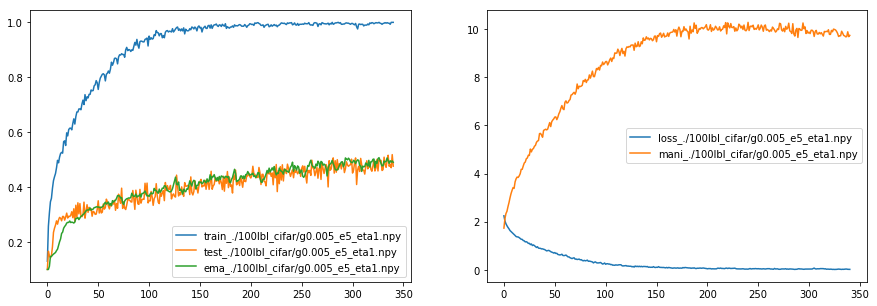

Epoch: 341,global_stp: 6840, xloss: 0.01742, maniloss: 9.68279, train: 100.00%, test: 48.91,test_ma: 49.36%
Epoch: 342,global_stp: 6860, xloss: 0.01824, maniloss: 9.65139, train: 99.80%, test: 48.65,test_ma: 50.38%
Epoch: 343,global_stp: 6880, xloss: 0.02722, maniloss: 9.88877, train: 99.50%, test: 46.99,test_ma: 51.36%
Epoch: 344,global_stp: 6900, xloss: 0.02794, maniloss: 9.72500, train: 99.70%, test: 53.62,test_ma: 50.70%
Epoch: 345,global_stp: 6920, xloss: 0.03101, maniloss: 9.70586, train: 99.60%, test: 51.78,test_ma: 48.25%
Epoch: 346,global_stp: 6940, xloss: 0.02354, maniloss: 9.62210, train: 99.60%, test: 48.70,test_ma: 48.84%
Epoch: 347,global_stp: 6960, xloss: 0.02551, maniloss: 9.56525, train: 99.40%, test: 45.37,test_ma: 51.32%
Epoch: 348,global_stp: 6980, xloss: 0.02428, maniloss: 9.65654, train: 99.60%, test: 47.99,test_ma: 51.09%
Epoch: 349,global_stp: 7000, xloss: 0.02613, maniloss: 9.63355, train: 99.70%, test: 46.25,test_ma: 52.68%
Epoch: 350,global_stp: 7020, xloss: 

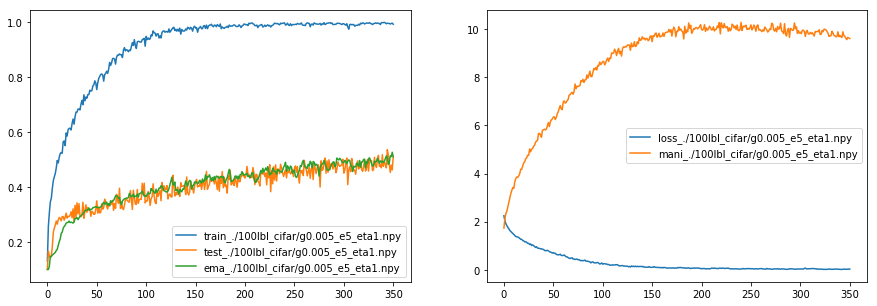

Epoch: 351,global_stp: 7040, xloss: 0.03686, maniloss: 9.46404, train: 99.30%, test: 49.39,test_ma: 50.83%
Epoch: 352,global_stp: 7060, xloss: 0.04080, maniloss: 9.73944, train: 99.30%, test: 46.56,test_ma: 49.96%
Epoch: 353,global_stp: 7080, xloss: 0.03447, maniloss: 9.63408, train: 99.20%, test: 46.49,test_ma: 50.39%
Epoch: 354,global_stp: 7100, xloss: 0.03296, maniloss: 9.68170, train: 99.30%, test: 48.30,test_ma: 49.99%
Epoch: 355,global_stp: 7120, xloss: 0.04932, maniloss: 9.84051, train: 99.10%, test: 43.56,test_ma: 49.89%
Epoch: 356,global_stp: 7140, xloss: 0.05974, maniloss: 9.62207, train: 98.60%, test: 47.11,test_ma: 51.46%
Epoch: 357,global_stp: 7160, xloss: 0.04045, maniloss: 9.70649, train: 99.30%, test: 51.23,test_ma: 50.54%
Epoch: 358,global_stp: 7180, xloss: 0.02949, maniloss: 9.86459, train: 99.80%, test: 48.76,test_ma: 50.40%
Epoch: 359,global_stp: 7200, xloss: 0.02336, maniloss: 9.63622, train: 99.70%, test: 51.80,test_ma: 51.26%
Epoch: 360,global_stp: 7220, xloss: 0

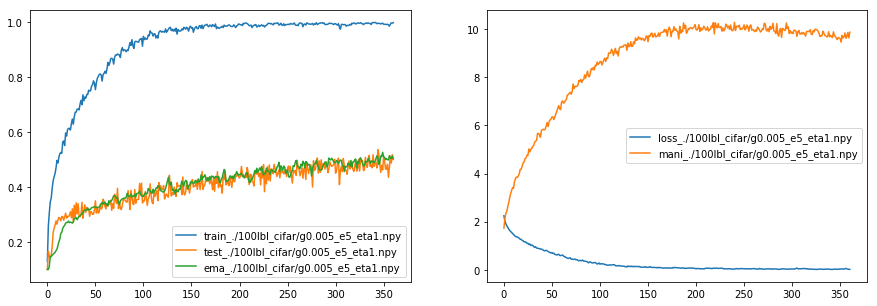

Epoch: 361,global_stp: 7240, xloss: 0.02590, maniloss: 9.82324, train: 99.70%, test: 49.18,test_ma: 51.15%
Epoch: 362,global_stp: 7260, xloss: 0.01762, maniloss: 9.65246, train: 99.90%, test: 47.56,test_ma: 51.89%
Epoch: 363,global_stp: 7280, xloss: 0.02157, maniloss: 9.61469, train: 99.90%, test: 49.74,test_ma: 53.48%
Epoch: 364,global_stp: 7300, xloss: 0.01471, maniloss: 9.52119, train: 100.00%, test: 50.14,test_ma: 52.64%
Epoch: 365,global_stp: 7320, xloss: 0.02369, maniloss: 9.41026, train: 99.60%, test: 52.60,test_ma: 53.10%
Epoch: 366,global_stp: 7340, xloss: 0.02221, maniloss: 9.61997, train: 99.90%, test: 50.03,test_ma: 53.11%
Epoch: 367,global_stp: 7360, xloss: 0.02887, maniloss: 9.42620, train: 99.60%, test: 48.17,test_ma: 52.39%
Epoch: 368,global_stp: 7380, xloss: 0.02314, maniloss: 9.41383, train: 99.60%, test: 50.83,test_ma: 53.22%
Epoch: 369,global_stp: 7400, xloss: 0.03003, maniloss: 9.97475, train: 99.50%, test: 49.70,test_ma: 52.71%
Epoch: 370,global_stp: 7420, xloss: 

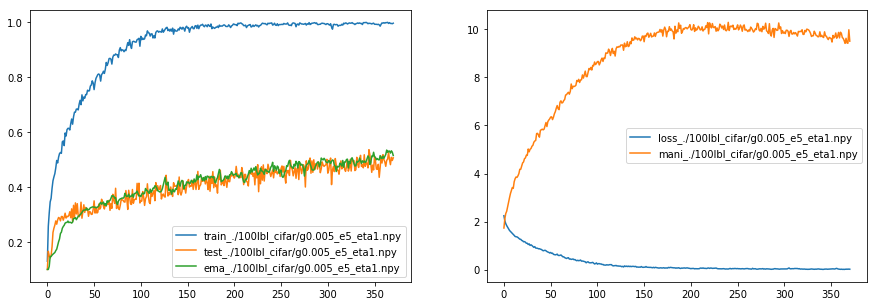

Epoch: 371,global_stp: 7440, xloss: 0.02653, maniloss: 9.59080, train: 99.70%, test: 48.99,test_ma: 50.98%
Epoch: 372,global_stp: 7460, xloss: 0.01973, maniloss: 9.47931, train: 99.90%, test: 48.82,test_ma: 52.49%
Epoch: 373,global_stp: 7480, xloss: 0.01687, maniloss: 9.53697, train: 99.90%, test: 52.18,test_ma: 52.66%
Epoch: 374,global_stp: 7500, xloss: 0.02402, maniloss: 9.47471, train: 99.60%, test: 49.98,test_ma: 52.14%
Epoch: 375,global_stp: 7520, xloss: 0.02370, maniloss: 9.63258, train: 99.70%, test: 50.34,test_ma: 52.37%
Epoch: 376,global_stp: 7540, xloss: 0.02540, maniloss: 9.67593, train: 99.70%, test: 47.39,test_ma: 52.89%
Epoch: 377,global_stp: 7560, xloss: 0.02609, maniloss: 9.50948, train: 99.90%, test: 52.34,test_ma: 52.01%
Epoch: 378,global_stp: 7580, xloss: 0.02666, maniloss: 9.43743, train: 99.40%, test: 50.58,test_ma: 49.06%
Epoch: 379,global_stp: 7600, xloss: 0.02945, maniloss: 9.32192, train: 99.60%, test: 50.77,test_ma: 51.61%
Epoch: 380,global_stp: 7620, xloss: 0

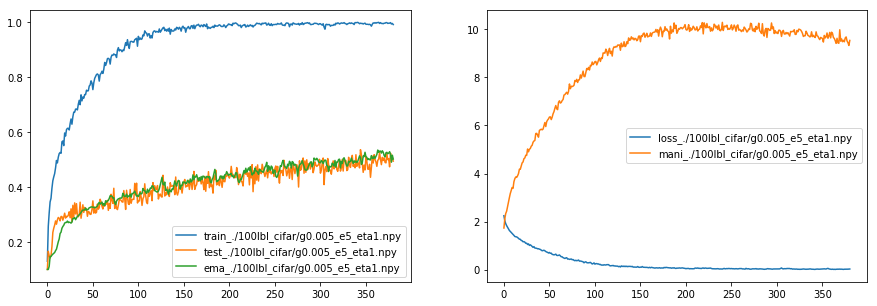

Epoch: 381,global_stp: 7640, xloss: 0.04191, maniloss: 9.64437, train: 99.30%, test: 51.17,test_ma: 50.91%
Epoch: 382,global_stp: 7660, xloss: 0.03004, maniloss: 9.55010, train: 99.40%, test: 52.77,test_ma: 49.03%
Epoch: 383,global_stp: 7680, xloss: 0.02918, maniloss: 9.64700, train: 99.60%, test: 48.70,test_ma: 47.71%
Epoch: 384,global_stp: 7700, xloss: 0.03842, maniloss: 9.36224, train: 99.50%, test: 50.04,test_ma: 49.43%
Epoch: 385,global_stp: 7720, xloss: 0.02314, maniloss: 9.44403, train: 99.90%, test: 51.40,test_ma: 49.55%
Epoch: 386,global_stp: 7740, xloss: 0.01984, maniloss: 9.50426, train: 99.80%, test: 46.61,test_ma: 51.18%
Epoch: 387,global_stp: 7760, xloss: 0.01897, maniloss: 9.66452, train: 99.80%, test: 47.89,test_ma: 51.83%
Epoch: 388,global_stp: 7780, xloss: 0.02078, maniloss: 9.44159, train: 99.70%, test: 51.09,test_ma: 52.74%
Epoch: 389,global_stp: 7800, xloss: 0.02113, maniloss: 9.32317, train: 99.90%, test: 50.65,test_ma: 52.41%
Epoch: 390,global_stp: 7820, xloss: 0

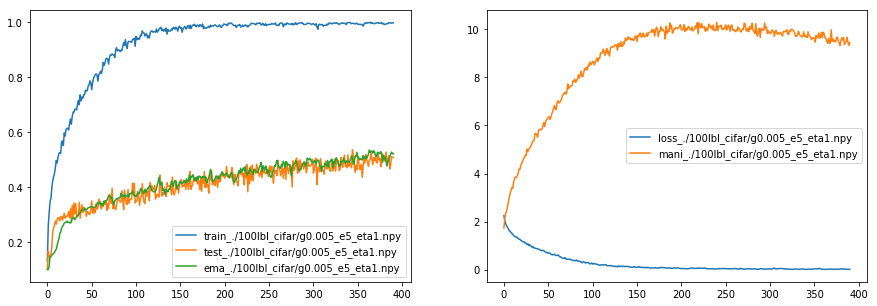

Epoch: 391,global_stp: 7840, xloss: 0.01933, maniloss: 9.55218, train: 99.80%, test: 49.53,test_ma: 52.00%
Epoch: 392,global_stp: 7860, xloss: 0.01629, maniloss: 9.59991, train: 100.00%, test: 47.53,test_ma: 53.31%
Epoch: 393,global_stp: 7880, xloss: 0.01245, maniloss: 9.45343, train: 100.00%, test: 49.13,test_ma: 53.83%
Epoch: 394,global_stp: 7900, xloss: 0.02148, maniloss: 9.36392, train: 99.50%, test: 50.03,test_ma: 54.00%
Epoch: 395,global_stp: 7920, xloss: 0.01621, maniloss: 9.26575, train: 99.90%, test: 51.26,test_ma: 53.19%
Epoch: 396,global_stp: 7940, xloss: 0.01357, maniloss: 9.40111, train: 100.00%, test: 51.74,test_ma: 52.68%
Epoch: 397,global_stp: 7960, xloss: 0.01554, maniloss: 9.35035, train: 99.80%, test: 51.29,test_ma: 53.18%
Epoch: 398,global_stp: 7980, xloss: 0.01394, maniloss: 9.13473, train: 99.80%, test: 50.91,test_ma: 52.75%
Epoch: 399,global_stp: 8000, xloss: 0.01341, maniloss: 9.19986, train: 100.00%, test: 50.77,test_ma: 52.63%
Epoch: 400,global_stp: 8020, xlos

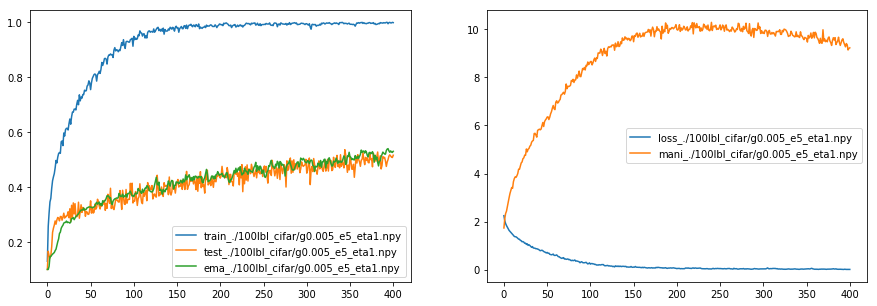

Epoch: 401,global_stp: 8040, xloss: 0.01455, maniloss: 9.31604, train: 99.80%, test: 51.39,test_ma: 52.79%
Epoch: 402,global_stp: 8060, xloss: 0.01242, maniloss: 9.24284, train: 99.90%, test: 52.55,test_ma: 52.25%
Epoch: 403,global_stp: 8080, xloss: 0.02216, maniloss: 9.19614, train: 99.80%, test: 50.07,test_ma: 52.08%
Epoch: 404,global_stp: 8100, xloss: 0.01876, maniloss: 9.36968, train: 99.70%, test: 49.50,test_ma: 52.85%
Epoch: 405,global_stp: 8120, xloss: 0.02213, maniloss: 9.14148, train: 99.90%, test: 52.29,test_ma: 51.93%
Epoch: 406,global_stp: 8140, xloss: 0.02445, maniloss: 9.23447, train: 99.50%, test: 51.71,test_ma: 51.10%
Epoch: 407,global_stp: 8160, xloss: 0.02258, maniloss: 9.45653, train: 99.60%, test: 46.77,test_ma: 52.74%
Epoch: 408,global_stp: 8180, xloss: 0.02433, maniloss: 9.32092, train: 99.70%, test: 52.15,test_ma: 51.24%
Epoch: 409,global_stp: 8200, xloss: 0.02393, maniloss: 9.37724, train: 99.70%, test: 50.88,test_ma: 51.13%
Epoch: 410,global_stp: 8220, xloss: 0

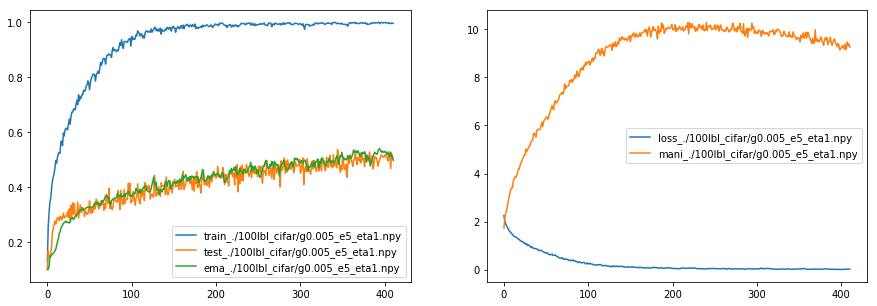

Epoch: 411,global_stp: 8240, xloss: 0.02393, maniloss: 9.44908, train: 99.70%, test: 50.18,test_ma: 51.87%
Epoch: 412,global_stp: 8260, xloss: 0.01768, maniloss: 9.28187, train: 99.90%, test: 51.09,test_ma: 52.20%
Epoch: 413,global_stp: 8280, xloss: 0.01790, maniloss: 9.14720, train: 99.90%, test: 51.04,test_ma: 52.45%
Epoch: 414,global_stp: 8300, xloss: 0.01649, maniloss: 9.22299, train: 99.90%, test: 50.29,test_ma: 51.95%
Epoch: 415,global_stp: 8320, xloss: 0.01614, maniloss: 9.28078, train: 100.00%, test: 53.79,test_ma: 52.86%
Epoch: 416,global_stp: 8340, xloss: 0.02538, maniloss: 9.20363, train: 99.60%, test: 47.37,test_ma: 52.15%
Epoch: 417,global_stp: 8360, xloss: 0.01480, maniloss: 9.18557, train: 100.00%, test: 52.59,test_ma: 51.26%
Epoch: 418,global_stp: 8380, xloss: 0.00915, maniloss: 9.03651, train: 100.00%, test: 50.69,test_ma: 51.06%
Epoch: 419,global_stp: 8400, xloss: 0.01107, maniloss: 9.30225, train: 100.00%, test: 51.37,test_ma: 50.93%
Epoch: 420,global_stp: 8420, xlos

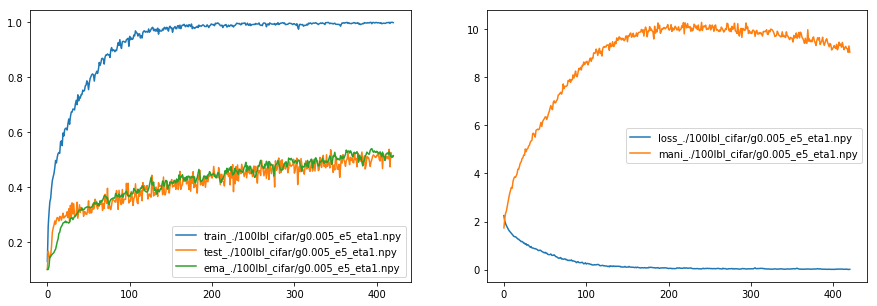

Epoch: 421,global_stp: 8440, xloss: 0.01002, maniloss: 9.19379, train: 100.00%, test: 52.41,test_ma: 51.69%
Epoch: 422,global_stp: 8460, xloss: 0.01055, maniloss: 9.07846, train: 100.00%, test: 51.35,test_ma: 51.76%
Epoch: 423,global_stp: 8480, xloss: 0.01709, maniloss: 9.02449, train: 99.70%, test: 50.99,test_ma: 52.00%
Epoch: 424,global_stp: 8500, xloss: 0.03427, maniloss: 8.83772, train: 99.40%, test: 52.24,test_ma: 52.52%
Epoch: 425,global_stp: 8520, xloss: 0.04603, maniloss: 9.07956, train: 98.90%, test: 49.30,test_ma: 51.18%
Epoch: 426,global_stp: 8540, xloss: 0.05503, maniloss: 8.97672, train: 98.60%, test: 45.00,test_ma: 52.95%
Epoch: 427,global_stp: 8560, xloss: 0.03547, maniloss: 9.07489, train: 99.50%, test: 48.29,test_ma: 52.74%
Epoch: 428,global_stp: 8580, xloss: 0.03262, maniloss: 9.16708, train: 99.50%, test: 51.09,test_ma: 51.68%
Epoch: 429,global_stp: 8600, xloss: 0.05099, maniloss: 9.23212, train: 98.60%, test: 50.58,test_ma: 50.17%
Epoch: 430,global_stp: 8620, xloss:

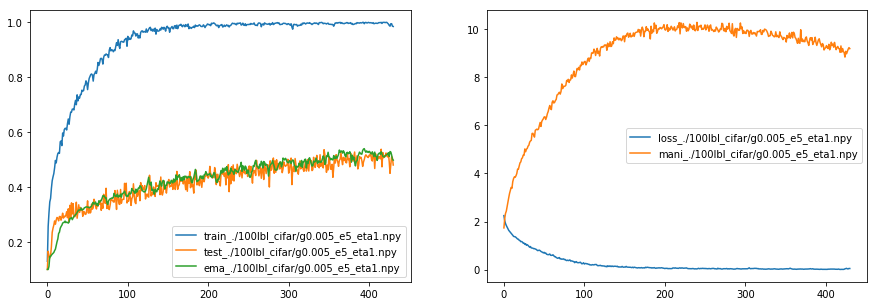

Epoch: 431,global_stp: 8640, xloss: 0.04376, maniloss: 9.36206, train: 99.00%, test: 45.67,test_ma: 51.22%
Epoch: 432,global_stp: 8660, xloss: 0.03073, maniloss: 9.17503, train: 99.40%, test: 51.28,test_ma: 52.45%
Epoch: 433,global_stp: 8680, xloss: 0.02990, maniloss: 9.10225, train: 99.70%, test: 46.72,test_ma: 50.62%
Epoch: 434,global_stp: 8700, xloss: 0.04383, maniloss: 9.10886, train: 99.20%, test: 50.60,test_ma: 51.04%
Epoch: 435,global_stp: 8720, xloss: 0.03449, maniloss: 8.99140, train: 99.60%, test: 51.55,test_ma: 51.02%
Epoch: 436,global_stp: 8740, xloss: 0.03573, maniloss: 9.33165, train: 99.40%, test: 49.72,test_ma: 50.12%
Epoch: 437,global_stp: 8760, xloss: 0.02630, maniloss: 9.35067, train: 99.80%, test: 51.58,test_ma: 50.30%
Epoch: 438,global_stp: 8780, xloss: 0.02444, maniloss: 9.32144, train: 99.60%, test: 51.67,test_ma: 49.09%
Epoch: 439,global_stp: 8800, xloss: 0.03125, maniloss: 9.13772, train: 99.30%, test: 48.32,test_ma: 51.22%
Epoch: 440,global_stp: 8820, xloss: 0

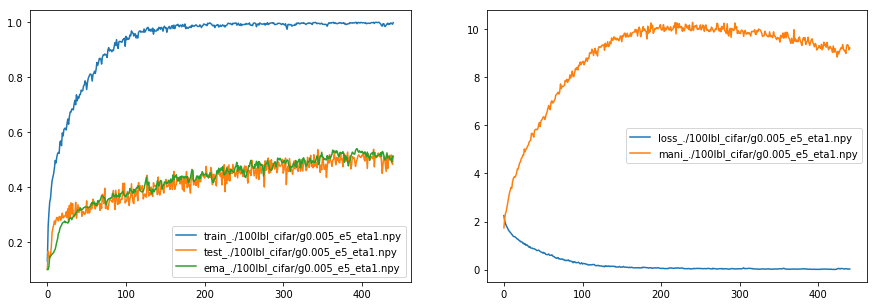

Epoch: 441,global_stp: 8840, xloss: 0.02092, maniloss: 9.29186, train: 99.80%, test: 52.17,test_ma: 50.53%
Epoch: 442,global_stp: 8860, xloss: 0.01744, maniloss: 9.24856, train: 99.80%, test: 49.49,test_ma: 50.88%
Epoch: 443,global_stp: 8880, xloss: 0.02371, maniloss: 9.23594, train: 99.60%, test: 52.07,test_ma: 49.78%
Epoch: 444,global_stp: 8900, xloss: 0.02137, maniloss: 9.31741, train: 100.00%, test: 47.98,test_ma: 50.66%
Epoch: 445,global_stp: 8920, xloss: 0.01378, maniloss: 9.21889, train: 99.90%, test: 52.54,test_ma: 53.11%
Epoch: 446,global_stp: 8940, xloss: 0.01187, maniloss: 9.16750, train: 100.00%, test: 54.07,test_ma: 52.38%
Epoch: 447,global_stp: 8960, xloss: 0.01781, maniloss: 9.30543, train: 99.80%, test: 51.83,test_ma: 51.37%
Epoch: 448,global_stp: 8980, xloss: 0.01961, maniloss: 9.07191, train: 99.70%, test: 52.63,test_ma: 51.79%
Epoch: 449,global_stp: 9000, xloss: 0.01222, maniloss: 9.14076, train: 99.90%, test: 52.99,test_ma: 50.77%
Epoch: 450,global_stp: 9020, xloss:

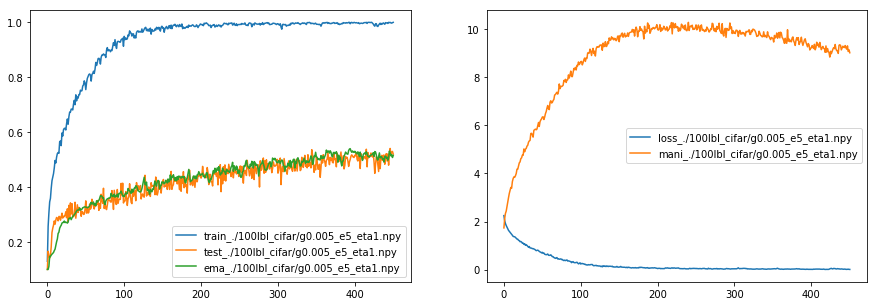

Epoch: 451,global_stp: 9040, xloss: 0.01289, maniloss: 9.06619, train: 99.90%, test: 49.94,test_ma: 52.27%
Epoch: 452,global_stp: 9060, xloss: 0.01076, maniloss: 8.91368, train: 100.00%, test: 53.91,test_ma: 52.38%
Epoch: 453,global_stp: 9080, xloss: 0.01089, maniloss: 8.85370, train: 99.90%, test: 53.62,test_ma: 52.02%
Epoch: 454,global_stp: 9100, xloss: 0.01477, maniloss: 9.06646, train: 99.70%, test: 51.57,test_ma: 53.14%
Epoch: 455,global_stp: 9120, xloss: 0.02288, maniloss: 8.88284, train: 99.60%, test: 49.66,test_ma: 54.73%
Epoch: 456,global_stp: 9140, xloss: 0.02563, maniloss: 9.01513, train: 99.60%, test: 51.11,test_ma: 55.33%
Epoch: 457,global_stp: 9160, xloss: 0.02066, maniloss: 8.92923, train: 99.90%, test: 52.21,test_ma: 54.14%
Epoch: 458,global_stp: 9180, xloss: 0.02190, maniloss: 8.90826, train: 99.60%, test: 52.64,test_ma: 54.18%
Epoch: 459,global_stp: 9200, xloss: 0.01984, maniloss: 9.11661, train: 99.70%, test: 52.91,test_ma: 53.08%
Epoch: 460,global_stp: 9220, xloss: 

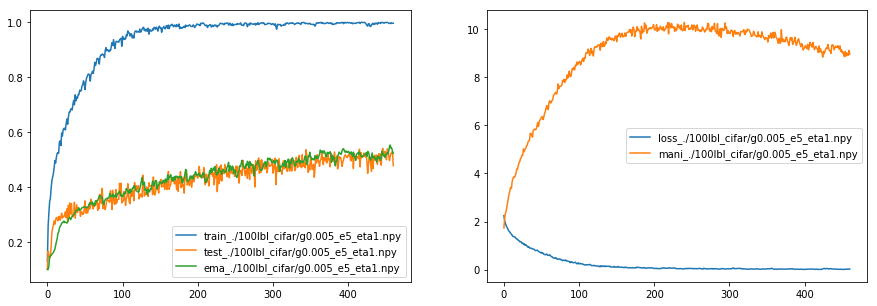

Epoch: 461,global_stp: 9240, xloss: 0.02674, maniloss: 9.04602, train: 99.60%, test: 50.04,test_ma: 52.48%
Epoch: 462,global_stp: 9260, xloss: 0.01535, maniloss: 8.93682, train: 99.90%, test: 51.92,test_ma: 50.71%
Epoch: 463,global_stp: 9280, xloss: 0.01330, maniloss: 8.94118, train: 100.00%, test: 54.61,test_ma: 50.48%
Epoch: 464,global_stp: 9300, xloss: 0.01034, maniloss: 8.69856, train: 99.90%, test: 49.32,test_ma: 50.41%
Epoch: 465,global_stp: 9320, xloss: 0.01660, maniloss: 8.71824, train: 99.70%, test: 50.76,test_ma: 52.84%
Epoch: 466,global_stp: 9340, xloss: 0.01620, maniloss: 8.86318, train: 99.80%, test: 51.82,test_ma: 52.15%
Epoch: 467,global_stp: 9360, xloss: 0.01284, maniloss: 9.00203, train: 100.00%, test: 52.28,test_ma: 51.72%
Epoch: 468,global_stp: 9380, xloss: 0.01504, maniloss: 8.84458, train: 99.90%, test: 50.20,test_ma: 52.42%
Epoch: 469,global_stp: 9400, xloss: 0.01192, maniloss: 9.01820, train: 99.90%, test: 51.86,test_ma: 53.62%
Epoch: 470,global_stp: 9420, xloss:

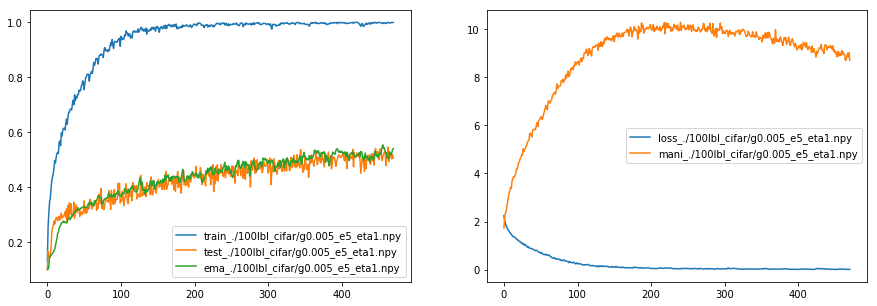

Epoch: 471,global_stp: 9440, xloss: 0.01361, maniloss: 8.86396, train: 99.90%, test: 54.34,test_ma: 53.89%
Epoch: 472,global_stp: 9460, xloss: 0.01848, maniloss: 8.79292, train: 99.70%, test: 50.97,test_ma: 52.63%
Epoch: 473,global_stp: 9480, xloss: 0.03065, maniloss: 9.00288, train: 99.60%, test: 51.86,test_ma: 51.93%
Epoch: 474,global_stp: 9500, xloss: 0.04285, maniloss: 8.77879, train: 99.00%, test: 49.91,test_ma: 52.21%
Epoch: 475,global_stp: 9520, xloss: 0.03072, maniloss: 8.80856, train: 99.60%, test: 47.12,test_ma: 52.41%
Epoch: 476,global_stp: 9540, xloss: 0.02629, maniloss: 8.90380, train: 99.80%, test: 53.34,test_ma: 53.87%
Epoch: 477,global_stp: 9560, xloss: 0.01903, maniloss: 8.80158, train: 99.90%, test: 51.80,test_ma: 52.25%
Epoch: 478,global_stp: 9580, xloss: 0.01515, maniloss: 8.87586, train: 99.80%, test: 51.27,test_ma: 53.04%
Epoch: 479,global_stp: 9600, xloss: 0.01108, maniloss: 8.80018, train: 100.00%, test: 53.69,test_ma: 53.70%
Epoch: 480,global_stp: 9620, xloss: 

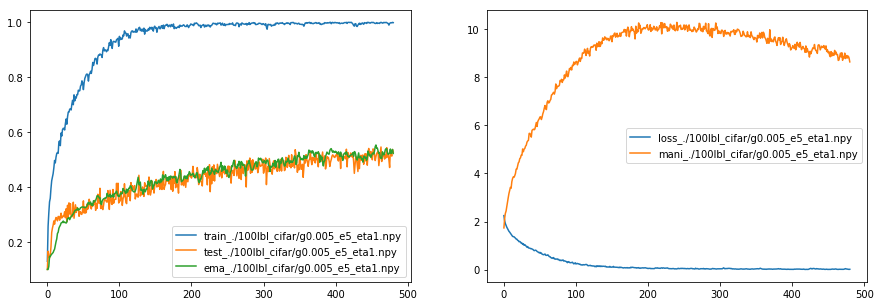

Epoch: 481,global_stp: 9640, xloss: 0.01034, maniloss: 8.68747, train: 100.00%, test: 50.68,test_ma: 52.31%
Epoch: 482,global_stp: 9660, xloss: 0.01712, maniloss: 8.71395, train: 99.90%, test: 51.68,test_ma: 53.10%
Epoch: 483,global_stp: 9680, xloss: 0.02006, maniloss: 8.84072, train: 99.60%, test: 52.89,test_ma: 54.07%
Epoch: 484,global_stp: 9700, xloss: 0.02228, maniloss: 8.76968, train: 99.70%, test: 52.51,test_ma: 53.29%
Epoch: 485,global_stp: 9720, xloss: 0.01564, maniloss: 8.78433, train: 99.90%, test: 53.15,test_ma: 53.76%
Epoch: 486,global_stp: 9740, xloss: 0.01573, maniloss: 8.90480, train: 99.70%, test: 51.89,test_ma: 53.30%
Epoch: 487,global_stp: 9760, xloss: 0.01736, maniloss: 8.88298, train: 99.70%, test: 51.63,test_ma: 52.11%
Epoch: 488,global_stp: 9780, xloss: 0.01864, maniloss: 8.69818, train: 99.80%, test: 53.47,test_ma: 52.82%
Epoch: 489,global_stp: 9800, xloss: 0.01504, maniloss: 8.93512, train: 100.00%, test: 51.43,test_ma: 51.88%
Epoch: 490,global_stp: 9820, xloss:

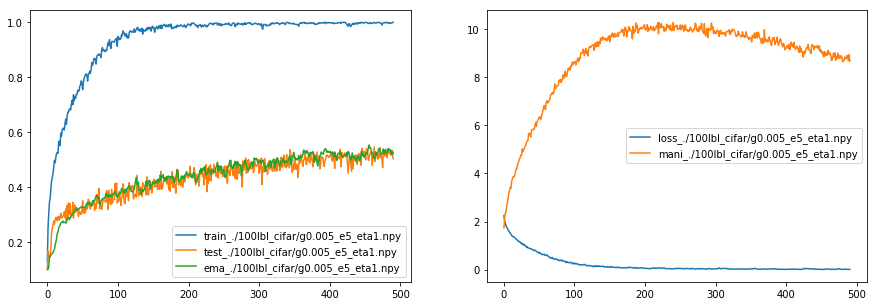

Epoch: 491,global_stp: 9840, xloss: 0.01314, maniloss: 8.65419, train: 100.00%, test: 51.38,test_ma: 53.81%
Epoch: 492,global_stp: 9860, xloss: 0.01017, maniloss: 8.58482, train: 100.00%, test: 53.00,test_ma: 53.85%
Epoch: 493,global_stp: 9880, xloss: 0.00949, maniloss: 8.83888, train: 100.00%, test: 51.70,test_ma: 54.16%
Epoch: 494,global_stp: 9900, xloss: 0.01247, maniloss: 8.59442, train: 99.90%, test: 53.12,test_ma: 53.48%
Epoch: 495,global_stp: 9920, xloss: 0.01656, maniloss: 8.63218, train: 99.90%, test: 53.31,test_ma: 52.67%
Epoch: 496,global_stp: 9940, xloss: 0.01325, maniloss: 8.69335, train: 99.90%, test: 52.91,test_ma: 52.56%
Epoch: 497,global_stp: 9960, xloss: 0.00844, maniloss: 8.65211, train: 100.00%, test: 53.46,test_ma: 53.98%
Epoch: 498,global_stp: 9980, xloss: 0.01031, maniloss: 8.71048, train: 100.00%, test: 55.04,test_ma: 53.82%
Epoch: 499,global_stp: 10000, xloss: 0.01132, maniloss: 8.71842, train: 100.00%, test: 54.45,test_ma: 53.13%
Epoch: 500,global_stp: 10020, 

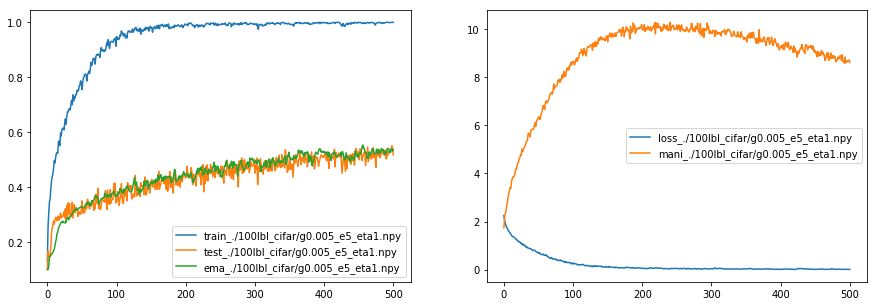

Epoch: 501,global_stp: 10040, xloss: 0.01652, maniloss: 8.66033, train: 99.90%, test: 51.49,test_ma: 54.60%
Epoch: 502,global_stp: 10060, xloss: 0.01530, maniloss: 8.89629, train: 99.80%, test: 52.40,test_ma: 54.11%
Epoch: 503,global_stp: 10080, xloss: 0.01390, maniloss: 8.47222, train: 100.00%, test: 51.32,test_ma: 54.07%
Epoch: 504,global_stp: 10100, xloss: 0.01419, maniloss: 8.60014, train: 99.90%, test: 50.27,test_ma: 54.48%
Epoch: 505,global_stp: 10120, xloss: 0.01799, maniloss: 8.41156, train: 99.80%, test: 51.51,test_ma: 55.49%
Epoch: 506,global_stp: 10140, xloss: 0.01469, maniloss: 8.68522, train: 99.80%, test: 53.26,test_ma: 54.08%
Epoch: 507,global_stp: 10160, xloss: 0.01373, maniloss: 8.67770, train: 100.00%, test: 54.35,test_ma: 52.93%
Epoch: 508,global_stp: 10180, xloss: 0.01321, maniloss: 8.72699, train: 99.80%, test: 54.51,test_ma: 51.20%
Epoch: 509,global_stp: 10200, xloss: 0.01438, maniloss: 8.56944, train: 99.90%, test: 52.41,test_ma: 50.68%
Epoch: 510,global_stp: 102

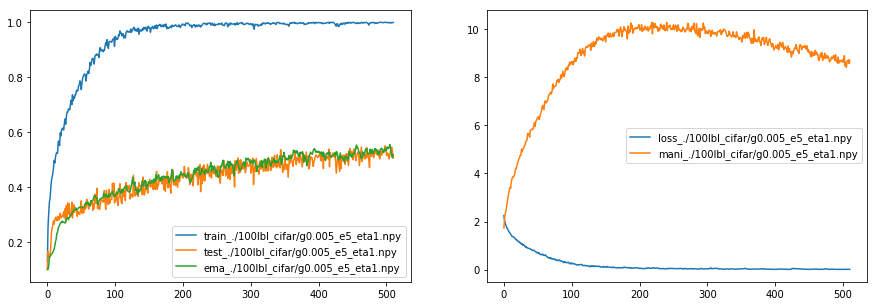

Epoch: 511,global_stp: 10240, xloss: 0.01466, maniloss: 8.31198, train: 99.90%, test: 54.23,test_ma: 52.27%
Epoch: 512,global_stp: 10260, xloss: 0.01606, maniloss: 8.23536, train: 99.90%, test: 49.26,test_ma: 52.30%
Epoch: 513,global_stp: 10280, xloss: 0.01367, maniloss: 8.44158, train: 99.90%, test: 51.16,test_ma: 53.03%
Epoch: 514,global_stp: 10300, xloss: 0.02488, maniloss: 8.50920, train: 99.50%, test: 47.59,test_ma: 52.48%
Epoch: 515,global_stp: 10320, xloss: 0.03307, maniloss: 8.47187, train: 99.50%, test: 50.81,test_ma: 51.54%
Epoch: 516,global_stp: 10340, xloss: 0.03843, maniloss: 8.46282, train: 99.00%, test: 45.90,test_ma: 51.67%
Epoch: 517,global_stp: 10360, xloss: 0.06264, maniloss: 8.47374, train: 98.20%, test: 44.54,test_ma: 52.58%
Epoch: 518,global_stp: 10380, xloss: 0.06574, maniloss: 8.72405, train: 98.10%, test: 46.47,test_ma: 54.22%
Epoch: 519,global_stp: 10400, xloss: 0.08609, maniloss: 8.72159, train: 97.60%, test: 50.79,test_ma: 54.35%
Epoch: 520,global_stp: 10420

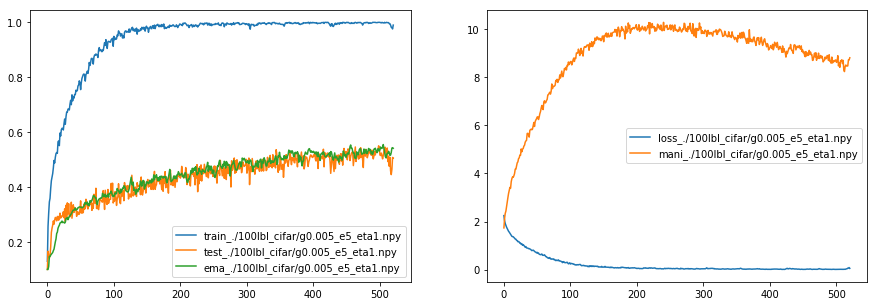

Epoch: 521,global_stp: 10440, xloss: 0.05026, maniloss: 8.84543, train: 98.90%, test: 51.00,test_ma: 52.37%
Epoch: 522,global_stp: 10460, xloss: 0.03286, maniloss: 8.94739, train: 99.70%, test: 51.36,test_ma: 52.35%
Epoch: 523,global_stp: 10480, xloss: 0.03111, maniloss: 8.94215, train: 99.50%, test: 49.69,test_ma: 51.75%
Epoch: 524,global_stp: 10500, xloss: 0.02928, maniloss: 8.83800, train: 99.50%, test: 49.88,test_ma: 52.38%
Epoch: 525,global_stp: 10520, xloss: 0.02196, maniloss: 8.89880, train: 99.70%, test: 52.71,test_ma: 53.15%
Epoch: 526,global_stp: 10540, xloss: 0.01876, maniloss: 8.89337, train: 99.90%, test: 54.29,test_ma: 51.90%
Epoch: 527,global_stp: 10560, xloss: 0.01834, maniloss: 8.86466, train: 99.80%, test: 52.13,test_ma: 51.70%
Epoch: 528,global_stp: 10580, xloss: 0.02427, maniloss: 8.85962, train: 99.70%, test: 50.46,test_ma: 52.84%
Epoch: 529,global_stp: 10600, xloss: 0.01269, maniloss: 8.62101, train: 99.80%, test: 51.52,test_ma: 53.13%
Epoch: 530,global_stp: 10620

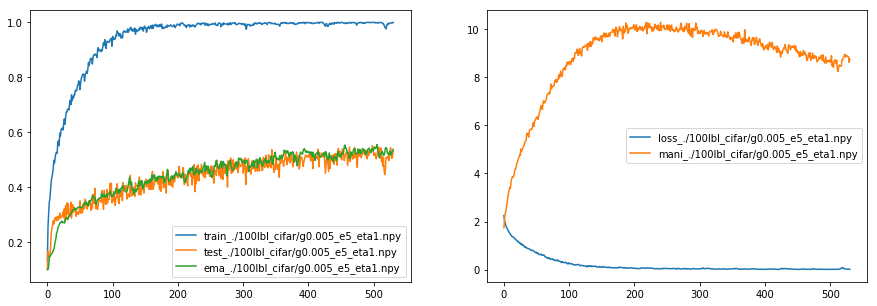

Epoch: 531,global_stp: 10640, xloss: 0.01135, maniloss: 8.83341, train: 99.90%, test: 54.19,test_ma: 53.46%
Epoch: 532,global_stp: 10660, xloss: 0.01086, maniloss: 8.77859, train: 100.00%, test: 52.51,test_ma: 53.27%
Epoch: 533,global_stp: 10680, xloss: 0.01173, maniloss: 8.73425, train: 99.80%, test: 55.25,test_ma: 53.11%
Epoch: 534,global_stp: 10700, xloss: 0.01151, maniloss: 8.50718, train: 100.00%, test: 53.76,test_ma: 52.49%
Epoch: 535,global_stp: 10720, xloss: 0.01462, maniloss: 8.56944, train: 99.90%, test: 52.19,test_ma: 53.89%
Epoch: 536,global_stp: 10740, xloss: 0.01236, maniloss: 8.74011, train: 99.90%, test: 53.50,test_ma: 54.56%
Epoch: 537,global_stp: 10760, xloss: 0.00961, maniloss: 8.60070, train: 99.90%, test: 53.34,test_ma: 55.12%
Epoch: 538,global_stp: 10780, xloss: 0.00947, maniloss: 8.64494, train: 100.00%, test: 53.09,test_ma: 55.96%
Epoch: 539,global_stp: 10800, xloss: 0.01129, maniloss: 8.52806, train: 99.90%, test: 54.73,test_ma: 55.48%
Epoch: 540,global_stp: 10

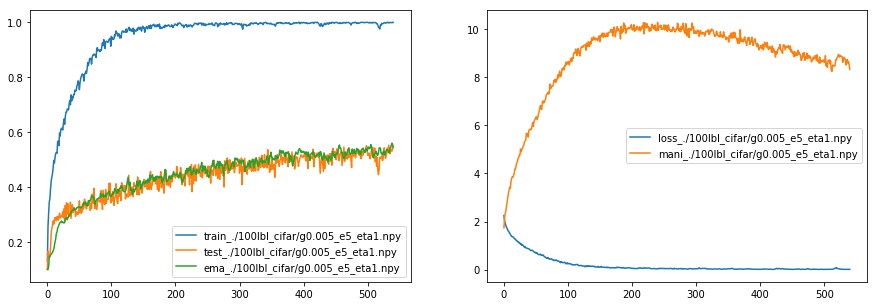

Epoch: 541,global_stp: 10840, xloss: 0.01310, maniloss: 8.29712, train: 99.80%, test: 53.30,test_ma: 53.82%
Epoch: 542,global_stp: 10860, xloss: 0.00972, maniloss: 8.41393, train: 100.00%, test: 53.00,test_ma: 52.88%
Epoch: 543,global_stp: 10880, xloss: 0.00964, maniloss: 8.46864, train: 100.00%, test: 53.94,test_ma: 53.27%
Epoch: 544,global_stp: 10900, xloss: 0.01294, maniloss: 8.39647, train: 100.00%, test: 53.86,test_ma: 53.63%
Epoch: 545,global_stp: 10920, xloss: 0.01690, maniloss: 8.46621, train: 99.80%, test: 50.88,test_ma: 53.47%
Epoch: 546,global_stp: 10940, xloss: 0.02269, maniloss: 8.25831, train: 99.70%, test: 52.69,test_ma: 54.82%
Epoch: 547,global_stp: 10960, xloss: 0.02181, maniloss: 8.34415, train: 99.80%, test: 54.07,test_ma: 54.12%
Epoch: 548,global_stp: 10980, xloss: 0.02124, maniloss: 8.46350, train: 99.80%, test: 52.42,test_ma: 54.36%
Epoch: 549,global_stp: 11000, xloss: 0.02038, maniloss: 8.43011, train: 99.60%, test: 52.27,test_ma: 53.74%
Epoch: 550,global_stp: 11

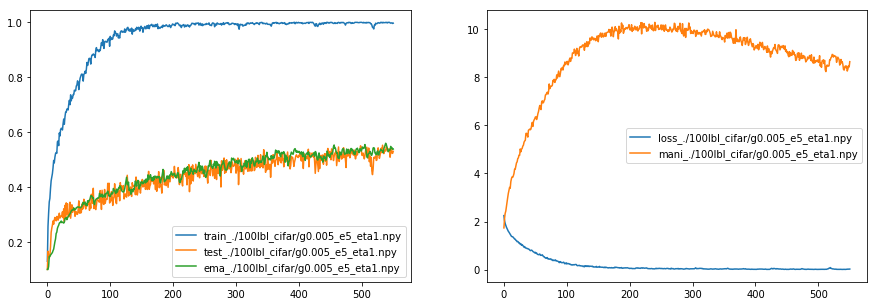

Epoch: 551,global_stp: 11040, xloss: 0.01788, maniloss: 8.59059, train: 99.70%, test: 49.88,test_ma: 52.79%
Epoch: 552,global_stp: 11060, xloss: 0.01939, maniloss: 8.59683, train: 99.60%, test: 54.24,test_ma: 52.83%
Epoch: 553,global_stp: 11080, xloss: 0.01658, maniloss: 8.44557, train: 99.80%, test: 51.13,test_ma: 53.75%
Epoch: 554,global_stp: 11100, xloss: 0.01457, maniloss: 8.37501, train: 99.90%, test: 49.84,test_ma: 55.29%
Epoch: 555,global_stp: 11120, xloss: 0.01197, maniloss: 8.41733, train: 99.90%, test: 52.61,test_ma: 55.29%
Epoch: 556,global_stp: 11140, xloss: 0.00743, maniloss: 8.29114, train: 100.00%, test: 53.32,test_ma: 55.05%
Epoch: 557,global_stp: 11160, xloss: 0.00949, maniloss: 8.24227, train: 100.00%, test: 51.90,test_ma: 54.65%
Epoch: 558,global_stp: 11180, xloss: 0.01068, maniloss: 8.13897, train: 99.90%, test: 51.13,test_ma: 55.46%
Epoch: 559,global_stp: 11200, xloss: 0.01047, maniloss: 8.10412, train: 100.00%, test: 54.68,test_ma: 54.69%
Epoch: 560,global_stp: 11

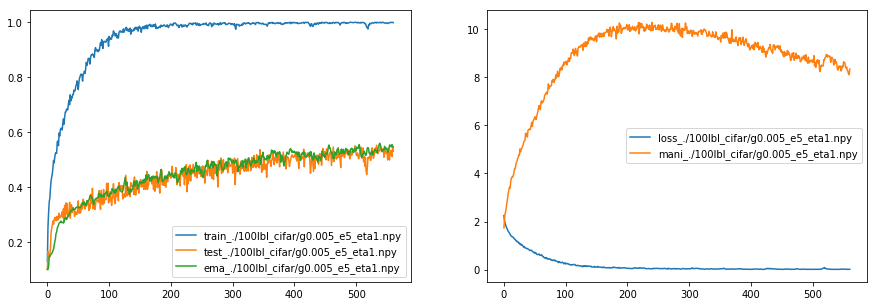

Epoch: 561,global_stp: 11240, xloss: 0.01027, maniloss: 8.33667, train: 100.00%, test: 53.20,test_ma: 54.81%
Epoch: 562,global_stp: 11260, xloss: 0.00919, maniloss: 8.31258, train: 100.00%, test: 54.18,test_ma: 55.16%
Epoch: 563,global_stp: 11280, xloss: 0.01157, maniloss: 8.27903, train: 100.00%, test: 52.43,test_ma: 55.00%
Epoch: 564,global_stp: 11300, xloss: 0.00943, maniloss: 8.36403, train: 100.00%, test: 54.85,test_ma: 55.02%
Epoch: 565,global_stp: 11320, xloss: 0.00754, maniloss: 8.12735, train: 100.00%, test: 54.39,test_ma: 55.08%
Epoch: 566,global_stp: 11340, xloss: 0.00719, maniloss: 8.16044, train: 100.00%, test: 55.19,test_ma: 54.54%
Epoch: 567,global_stp: 11360, xloss: 0.00876, maniloss: 8.13057, train: 99.90%, test: 53.09,test_ma: 54.22%
Epoch: 568,global_stp: 11380, xloss: 0.01193, maniloss: 8.08161, train: 100.00%, test: 53.79,test_ma: 54.57%
Epoch: 569,global_stp: 11400, xloss: 0.01300, maniloss: 8.15094, train: 99.90%, test: 52.67,test_ma: 54.53%
Epoch: 570,global_stp

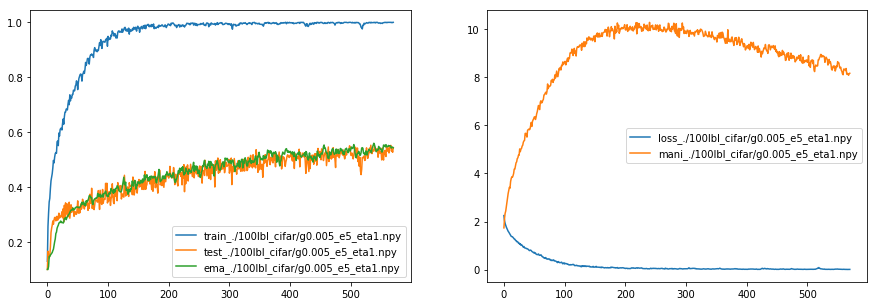

Epoch: 571,global_stp: 11440, xloss: 0.01192, maniloss: 8.08242, train: 99.80%, test: 51.33,test_ma: 55.28%
Epoch: 572,global_stp: 11460, xloss: 0.01629, maniloss: 8.02741, train: 99.70%, test: 55.13,test_ma: 55.76%
Epoch: 573,global_stp: 11480, xloss: 0.01317, maniloss: 7.93481, train: 99.90%, test: 51.38,test_ma: 54.51%
Epoch: 574,global_stp: 11500, xloss: 0.01247, maniloss: 8.01585, train: 100.00%, test: 53.90,test_ma: 54.91%
Epoch: 575,global_stp: 11520, xloss: 0.00818, maniloss: 7.88740, train: 100.00%, test: 54.26,test_ma: 54.92%
Epoch: 576,global_stp: 11540, xloss: 0.00850, maniloss: 7.86605, train: 100.00%, test: 55.78,test_ma: 55.23%
Epoch: 577,global_stp: 11560, xloss: 0.00810, maniloss: 7.95464, train: 100.00%, test: 55.70,test_ma: 55.12%
Epoch: 578,global_stp: 11580, xloss: 0.00837, maniloss: 7.87309, train: 100.00%, test: 54.98,test_ma: 54.27%
Epoch: 579,global_stp: 11600, xloss: 0.00970, maniloss: 7.85722, train: 99.90%, test: 55.30,test_ma: 54.01%
Epoch: 580,global_stp: 

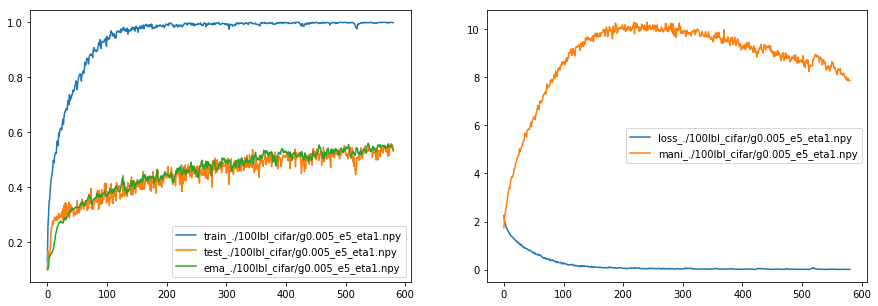

Epoch: 581,global_stp: 11640, xloss: 0.01342, maniloss: 7.82762, train: 100.00%, test: 53.53,test_ma: 54.78%
Epoch: 582,global_stp: 11660, xloss: 0.01372, maniloss: 7.96741, train: 99.80%, test: 53.88,test_ma: 54.91%
Epoch: 583,global_stp: 11680, xloss: 0.01655, maniloss: 7.97838, train: 99.90%, test: 52.23,test_ma: 55.27%
Epoch: 584,global_stp: 11700, xloss: 0.01411, maniloss: 8.06621, train: 99.90%, test: 53.83,test_ma: 54.21%
Epoch: 585,global_stp: 11720, xloss: 0.01553, maniloss: 8.08018, train: 99.80%, test: 55.20,test_ma: 53.78%
Epoch: 586,global_stp: 11740, xloss: 0.01314, maniloss: 8.03619, train: 99.90%, test: 52.69,test_ma: 53.97%
Epoch: 587,global_stp: 11760, xloss: 0.01113, maniloss: 8.07969, train: 100.00%, test: 54.72,test_ma: 54.25%
Epoch: 588,global_stp: 11780, xloss: 0.01049, maniloss: 8.00130, train: 100.00%, test: 54.97,test_ma: 54.32%
Epoch: 589,global_stp: 11800, xloss: 0.00867, maniloss: 7.93810, train: 100.00%, test: 54.34,test_ma: 54.08%
Epoch: 590,global_stp: 1

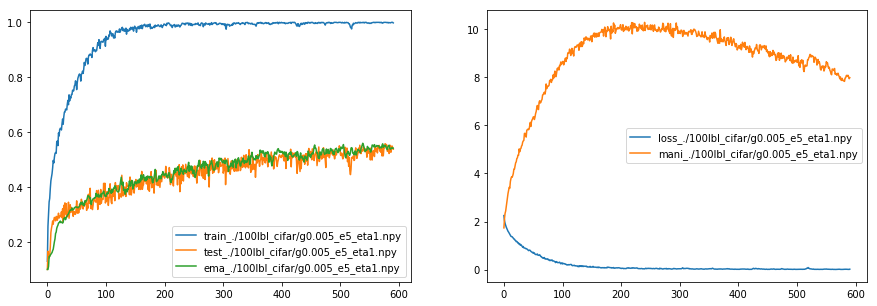

Epoch: 591,global_stp: 11840, xloss: 0.01535, maniloss: 8.07299, train: 99.90%, test: 51.60,test_ma: 53.92%
Epoch: 592,global_stp: 11860, xloss: 0.01256, maniloss: 7.95189, train: 99.90%, test: 52.13,test_ma: 54.79%
Epoch: 593,global_stp: 11880, xloss: 0.00924, maniloss: 7.97247, train: 100.00%, test: 54.78,test_ma: 55.31%
Epoch: 594,global_stp: 11900, xloss: 0.00722, maniloss: 8.06947, train: 100.00%, test: 54.28,test_ma: 54.82%
Epoch: 595,global_stp: 11920, xloss: 0.00766, maniloss: 7.96540, train: 99.90%, test: 54.94,test_ma: 54.96%
Epoch: 596,global_stp: 11940, xloss: 0.01038, maniloss: 7.98826, train: 100.00%, test: 53.04,test_ma: 55.66%
Epoch: 597,global_stp: 11960, xloss: 0.01237, maniloss: 7.82409, train: 100.00%, test: 53.20,test_ma: 55.63%
Epoch: 598,global_stp: 11980, xloss: 0.01126, maniloss: 7.75803, train: 99.90%, test: 54.93,test_ma: 55.39%
Epoch: 599,global_stp: 12000, xloss: 0.01272, maniloss: 7.78499, train: 99.90%, test: 53.61,test_ma: 55.38%
Epoch: 600,global_stp: 1

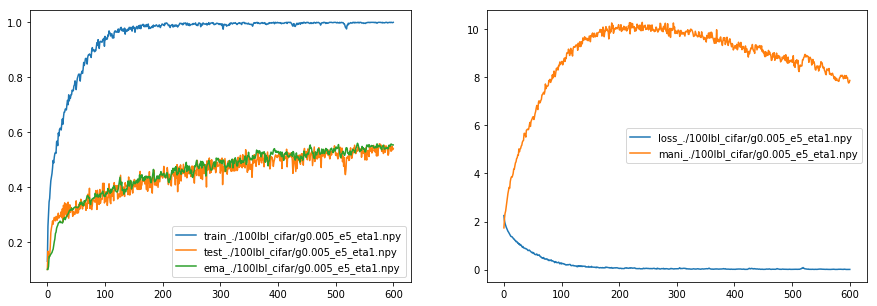

Epoch: 601,global_stp: 12040, xloss: 0.00885, maniloss: 7.78643, train: 100.00%, test: 55.91,test_ma: 54.91%
Epoch: 602,global_stp: 12060, xloss: 0.00768, maniloss: 7.85818, train: 100.00%, test: 55.05,test_ma: 55.62%
Epoch: 603,global_stp: 12080, xloss: 0.00799, maniloss: 7.95968, train: 100.00%, test: 55.38,test_ma: 55.49%
Epoch: 604,global_stp: 12100, xloss: 0.00720, maniloss: 7.70814, train: 100.00%, test: 54.51,test_ma: 55.56%
Epoch: 605,global_stp: 12120, xloss: 0.00676, maniloss: 7.82186, train: 100.00%, test: 54.98,test_ma: 56.40%
Epoch: 606,global_stp: 12140, xloss: 0.00871, maniloss: 7.66014, train: 100.00%, test: 55.23,test_ma: 55.65%
Epoch: 607,global_stp: 12160, xloss: 0.01040, maniloss: 7.66960, train: 100.00%, test: 52.79,test_ma: 55.50%
Epoch: 608,global_stp: 12180, xloss: 0.01273, maniloss: 7.55724, train: 99.90%, test: 53.75,test_ma: 56.17%
Epoch: 609,global_stp: 12200, xloss: 0.01171, maniloss: 7.50980, train: 100.00%, test: 54.21,test_ma: 55.96%
Epoch: 610,global_st

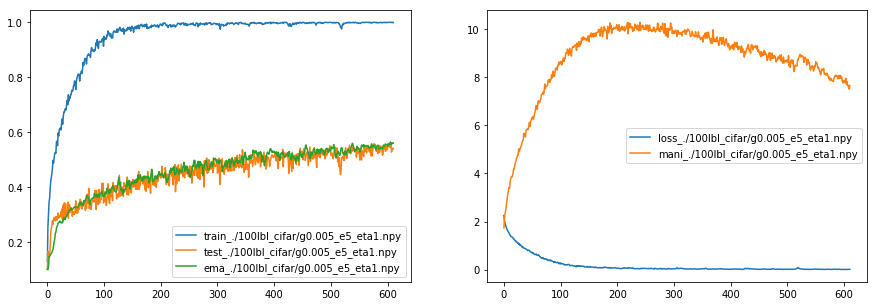

Epoch: 611,global_stp: 12240, xloss: 0.01703, maniloss: 7.82846, train: 99.80%, test: 52.65,test_ma: 56.34%
Epoch: 612,global_stp: 12260, xloss: 0.02392, maniloss: 7.89385, train: 99.40%, test: 49.42,test_ma: 56.09%
Epoch: 613,global_stp: 12280, xloss: 0.05324, maniloss: 8.06984, train: 98.40%, test: 50.01,test_ma: 55.47%
Epoch: 614,global_stp: 12300, xloss: 0.06524, maniloss: 8.24536, train: 98.40%, test: 49.49,test_ma: 54.96%
Epoch: 615,global_stp: 12320, xloss: 0.04175, maniloss: 8.20515, train: 98.90%, test: 50.08,test_ma: 53.78%
Epoch: 616,global_stp: 12340, xloss: 0.03568, maniloss: 8.13063, train: 99.30%, test: 52.41,test_ma: 51.60%
Epoch: 617,global_stp: 12360, xloss: 0.02775, maniloss: 8.35393, train: 99.50%, test: 51.87,test_ma: 52.02%
Epoch: 618,global_stp: 12380, xloss: 0.01787, maniloss: 8.32683, train: 99.80%, test: 51.76,test_ma: 51.40%
Epoch: 619,global_stp: 12400, xloss: 0.01752, maniloss: 8.43339, train: 100.00%, test: 50.71,test_ma: 53.71%
Epoch: 620,global_stp: 1242

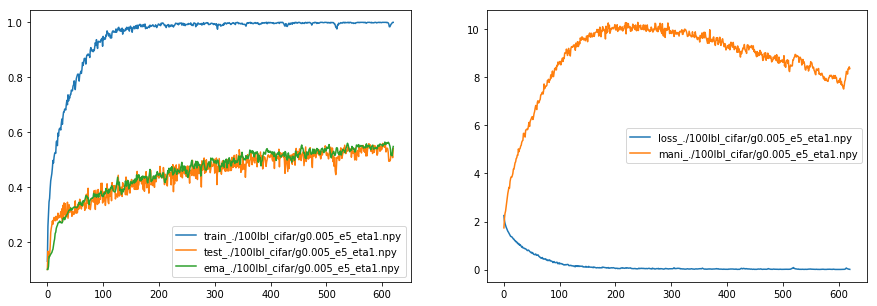

Epoch: 621,global_stp: 12440, xloss: 0.01073, maniloss: 8.26881, train: 99.80%, test: 53.38,test_ma: 55.25%
Epoch: 622,global_stp: 12460, xloss: 0.01184, maniloss: 8.20154, train: 99.80%, test: 53.84,test_ma: 55.01%
Epoch: 623,global_stp: 12480, xloss: 0.01249, maniloss: 8.16946, train: 99.90%, test: 53.82,test_ma: 54.91%
Epoch: 624,global_stp: 12500, xloss: 0.01793, maniloss: 8.11776, train: 99.80%, test: 53.48,test_ma: 54.79%
Epoch: 625,global_stp: 12520, xloss: 0.01506, maniloss: 8.12001, train: 99.70%, test: 55.00,test_ma: 53.92%
Epoch: 626,global_stp: 12540, xloss: 0.01001, maniloss: 8.14081, train: 100.00%, test: 53.98,test_ma: 53.70%
Epoch: 627,global_stp: 12560, xloss: 0.00871, maniloss: 8.19257, train: 100.00%, test: 54.78,test_ma: 54.21%
Epoch: 628,global_stp: 12580, xloss: 0.01094, maniloss: 7.92533, train: 99.90%, test: 54.52,test_ma: 53.46%
Epoch: 629,global_stp: 12600, xloss: 0.01123, maniloss: 8.07292, train: 100.00%, test: 53.05,test_ma: 53.94%
Epoch: 630,global_stp: 12

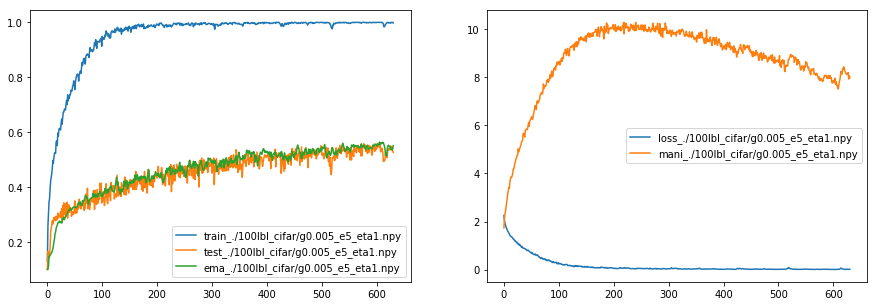

Epoch: 631,global_stp: 12640, xloss: 0.01709, maniloss: 8.05770, train: 99.80%, test: 53.19,test_ma: 55.03%
Epoch: 632,global_stp: 12660, xloss: 0.02115, maniloss: 8.09872, train: 99.70%, test: 49.73,test_ma: 55.99%
Epoch: 633,global_stp: 12680, xloss: 0.02672, maniloss: 8.20643, train: 99.50%, test: 55.70,test_ma: 54.65%
Epoch: 634,global_stp: 12700, xloss: 0.01702, maniloss: 8.00432, train: 99.80%, test: 53.48,test_ma: 55.01%
Epoch: 635,global_stp: 12720, xloss: 0.01261, maniloss: 8.23790, train: 99.90%, test: 53.83,test_ma: 54.77%
Epoch: 636,global_stp: 12740, xloss: 0.01510, maniloss: 8.13097, train: 99.80%, test: 52.90,test_ma: 55.20%
Epoch: 637,global_stp: 12760, xloss: 0.01374, maniloss: 8.19142, train: 99.90%, test: 54.91,test_ma: 54.60%
Epoch: 638,global_stp: 12780, xloss: 0.00860, maniloss: 7.88952, train: 100.00%, test: 54.99,test_ma: 54.27%
Epoch: 639,global_stp: 12800, xloss: 0.00965, maniloss: 8.16310, train: 100.00%, test: 54.18,test_ma: 54.17%
Epoch: 640,global_stp: 128

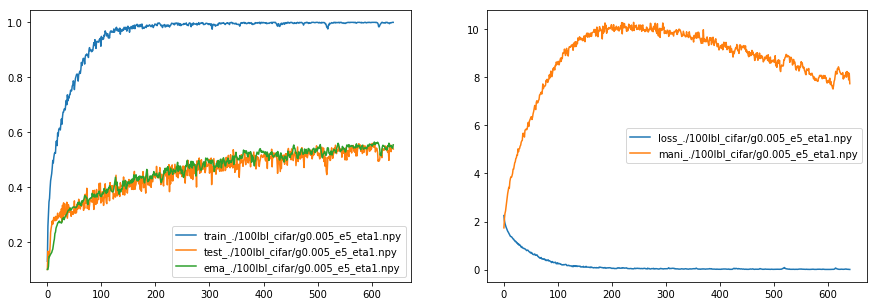

Epoch: 641,global_stp: 12840, xloss: 0.00841, maniloss: 7.84130, train: 100.00%, test: 54.25,test_ma: 56.25%
Epoch: 642,global_stp: 12860, xloss: 0.00689, maniloss: 7.85497, train: 100.00%, test: 55.23,test_ma: 56.29%
Epoch: 643,global_stp: 12880, xloss: 0.00594, maniloss: 7.75676, train: 100.00%, test: 55.47,test_ma: 56.77%
Epoch: 644,global_stp: 12900, xloss: 0.00541, maniloss: 7.62289, train: 100.00%, test: 56.06,test_ma: 56.14%
Epoch: 645,global_stp: 12920, xloss: 0.00737, maniloss: 7.57545, train: 100.00%, test: 55.44,test_ma: 55.67%
Epoch: 646,global_stp: 12940, xloss: 0.00550, maniloss: 7.52117, train: 100.00%, test: 55.38,test_ma: 55.38%
Epoch: 647,global_stp: 12960, xloss: 0.00664, maniloss: 7.50854, train: 100.00%, test: 56.79,test_ma: 54.94%
Epoch: 648,global_stp: 12980, xloss: 0.00855, maniloss: 7.53223, train: 100.00%, test: 54.30,test_ma: 54.74%
Epoch: 649,global_stp: 13000, xloss: 0.00708, maniloss: 7.37164, train: 100.00%, test: 54.55,test_ma: 55.44%
Epoch: 650,global_s

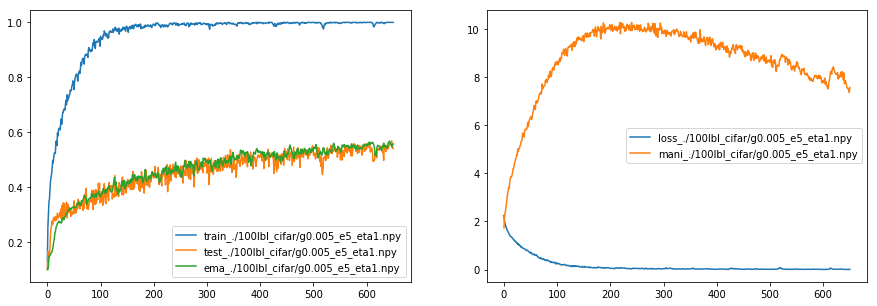

Epoch: 651,global_stp: 13040, xloss: 0.00866, maniloss: 7.36879, train: 100.00%, test: 54.98,test_ma: 55.80%
Epoch: 652,global_stp: 13060, xloss: 0.00717, maniloss: 7.41969, train: 100.00%, test: 55.88,test_ma: 55.81%
Epoch: 653,global_stp: 13080, xloss: 0.00664, maniloss: 7.45197, train: 99.90%, test: 56.73,test_ma: 55.95%
Epoch: 654,global_stp: 13100, xloss: 0.00680, maniloss: 7.28139, train: 100.00%, test: 54.88,test_ma: 55.66%
Epoch: 655,global_stp: 13120, xloss: 0.00927, maniloss: 7.48077, train: 100.00%, test: 53.94,test_ma: 55.59%
Epoch: 656,global_stp: 13140, xloss: 0.00784, maniloss: 7.28597, train: 100.00%, test: 54.34,test_ma: 55.92%
Epoch: 657,global_stp: 13160, xloss: 0.00741, maniloss: 7.31223, train: 100.00%, test: 56.01,test_ma: 56.53%
Epoch: 658,global_stp: 13180, xloss: 0.00958, maniloss: 7.25019, train: 99.90%, test: 56.85,test_ma: 55.90%
Epoch: 659,global_stp: 13200, xloss: 0.00941, maniloss: 7.18283, train: 100.00%, test: 54.73,test_ma: 55.33%
Epoch: 660,global_stp

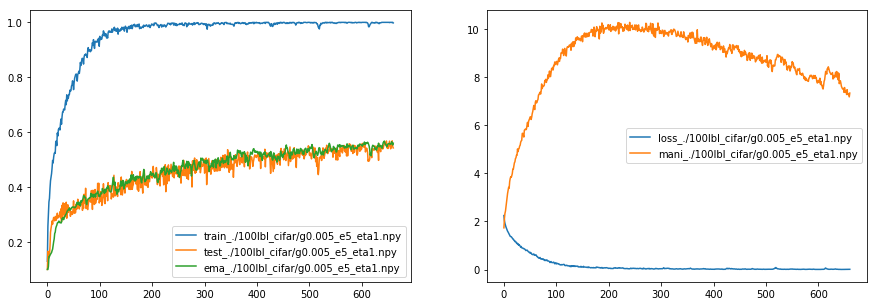

Epoch: 661,global_stp: 13240, xloss: 0.00736, maniloss: 7.34293, train: 100.00%, test: 55.33,test_ma: 56.24%
Epoch: 662,global_stp: 13260, xloss: 0.00716, maniloss: 7.27596, train: 100.00%, test: 55.40,test_ma: 56.42%
Epoch: 663,global_stp: 13280, xloss: 0.00794, maniloss: 7.22895, train: 100.00%, test: 55.15,test_ma: 56.27%
Epoch: 664,global_stp: 13300, xloss: 0.00799, maniloss: 7.33353, train: 100.00%, test: 54.79,test_ma: 56.03%
Epoch: 665,global_stp: 13320, xloss: 0.01172, maniloss: 7.37095, train: 99.90%, test: 53.76,test_ma: 55.92%
Epoch: 666,global_stp: 13340, xloss: 0.02746, maniloss: 7.30293, train: 99.50%, test: 47.56,test_ma: 56.32%
Epoch: 667,global_stp: 13360, xloss: 0.03315, maniloss: 7.43494, train: 99.40%, test: 53.54,test_ma: 56.24%
Epoch: 668,global_stp: 13380, xloss: 0.03098, maniloss: 7.62774, train: 99.50%, test: 51.73,test_ma: 54.69%
Epoch: 669,global_stp: 13400, xloss: 0.02264, maniloss: 7.78699, train: 99.80%, test: 52.76,test_ma: 53.85%
Epoch: 670,global_stp: 1

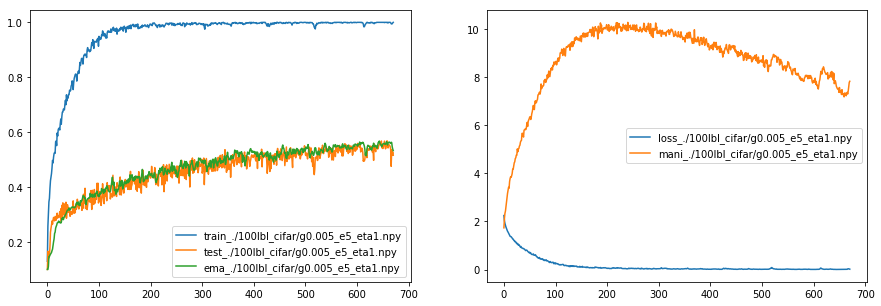

Epoch: 671,global_stp: 13440, xloss: 0.01170, maniloss: 7.93150, train: 100.00%, test: 51.72,test_ma: 53.44%
Epoch: 672,global_stp: 13460, xloss: 0.00801, maniloss: 7.92605, train: 100.00%, test: 55.31,test_ma: 53.81%
Epoch: 673,global_stp: 13480, xloss: 0.01219, maniloss: 7.86792, train: 99.80%, test: 49.59,test_ma: 53.98%
Epoch: 674,global_stp: 13500, xloss: 0.01506, maniloss: 7.83493, train: 99.90%, test: 52.09,test_ma: 54.89%
Epoch: 675,global_stp: 13520, xloss: 0.01664, maniloss: 7.80064, train: 99.60%, test: 56.24,test_ma: 53.93%
Epoch: 676,global_stp: 13540, xloss: 0.01523, maniloss: 7.75375, train: 99.90%, test: 51.85,test_ma: 52.66%
Epoch: 677,global_stp: 13560, xloss: 0.01407, maniloss: 7.78317, train: 100.00%, test: 52.46,test_ma: 55.20%
Epoch: 678,global_stp: 13580, xloss: 0.02281, maniloss: 7.71482, train: 99.60%, test: 54.59,test_ma: 55.30%
Epoch: 679,global_stp: 13600, xloss: 0.03365, maniloss: 7.77629, train: 99.30%, test: 50.92,test_ma: 53.38%
Epoch: 680,global_stp: 13

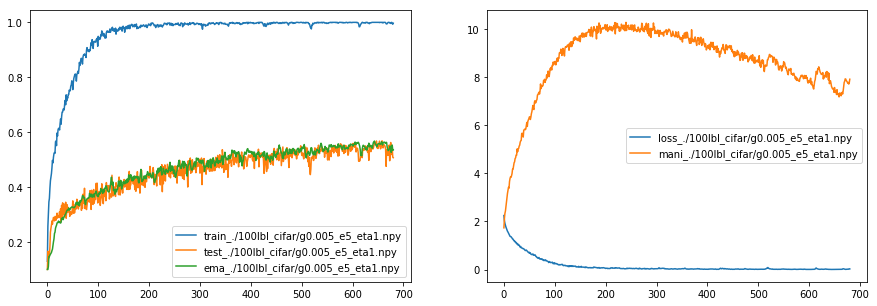

Epoch: 681,global_stp: 13640, xloss: 0.03242, maniloss: 7.97159, train: 99.10%, test: 47.08,test_ma: 52.15%
Epoch: 682,global_stp: 13660, xloss: 0.03437, maniloss: 7.84304, train: 99.40%, test: 51.07,test_ma: 53.58%
Epoch: 683,global_stp: 13680, xloss: 0.03299, maniloss: 8.21534, train: 99.00%, test: 50.69,test_ma: 52.35%
Epoch: 684,global_stp: 13700, xloss: 0.04647, maniloss: 8.12461, train: 98.90%, test: 50.31,test_ma: 50.08%
Epoch: 685,global_stp: 13720, xloss: 0.04453, maniloss: 7.95117, train: 99.10%, test: 50.35,test_ma: 49.89%
Epoch: 686,global_stp: 13740, xloss: 0.02902, maniloss: 8.13425, train: 99.50%, test: 51.50,test_ma: 51.68%
Epoch: 687,global_stp: 13760, xloss: 0.01823, maniloss: 8.34202, train: 99.90%, test: 53.23,test_ma: 51.75%
Epoch: 688,global_stp: 13780, xloss: 0.01449, maniloss: 8.18238, train: 99.90%, test: 52.64,test_ma: 52.98%
Epoch: 689,global_stp: 13800, xloss: 0.00907, maniloss: 8.12516, train: 100.00%, test: 52.89,test_ma: 54.75%
Epoch: 690,global_stp: 1382

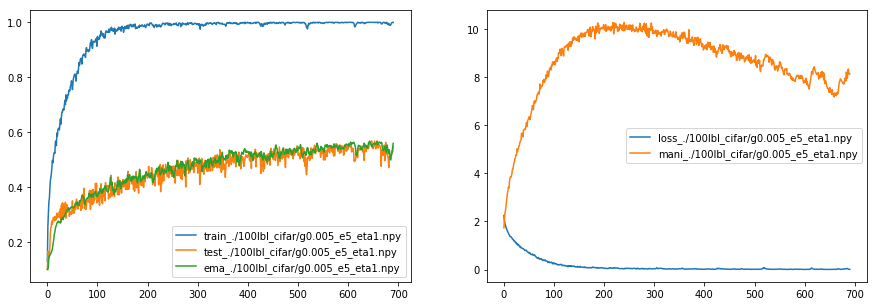

Epoch: 691,global_stp: 13840, xloss: 0.00861, maniloss: 8.07117, train: 100.00%, test: 53.06,test_ma: 56.44%
Epoch: 692,global_stp: 13860, xloss: 0.00869, maniloss: 7.96750, train: 100.00%, test: 53.55,test_ma: 56.72%
Epoch: 693,global_stp: 13880, xloss: 0.00944, maniloss: 7.87897, train: 99.90%, test: 53.75,test_ma: 57.07%
Epoch: 694,global_stp: 13900, xloss: 0.00831, maniloss: 7.93863, train: 99.90%, test: 55.53,test_ma: 56.75%
Epoch: 695,global_stp: 13920, xloss: 0.01020, maniloss: 7.90256, train: 99.90%, test: 56.20,test_ma: 55.71%
Epoch: 696,global_stp: 13940, xloss: 0.01429, maniloss: 7.72815, train: 99.80%, test: 53.51,test_ma: 55.19%
Epoch: 697,global_stp: 13960, xloss: 0.01752, maniloss: 7.90819, train: 99.80%, test: 53.92,test_ma: 56.47%
Epoch: 698,global_stp: 13980, xloss: 0.01281, maniloss: 7.78281, train: 100.00%, test: 55.50,test_ma: 56.21%
Epoch: 699,global_stp: 14000, xloss: 0.01381, maniloss: 7.76534, train: 99.90%, test: 55.75,test_ma: 55.94%
Epoch: 700,global_stp: 14

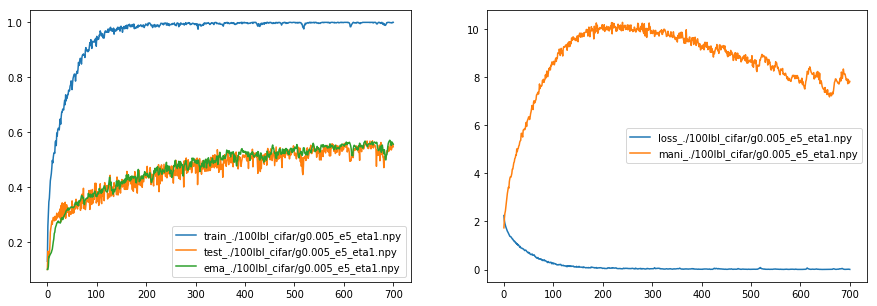

Epoch: 701,global_stp: 14040, xloss: 0.00884, maniloss: 7.71720, train: 100.00%, test: 54.09,test_ma: 56.03%
Epoch: 702,global_stp: 14060, xloss: 0.00726, maniloss: 7.77048, train: 100.00%, test: 53.67,test_ma: 56.67%
Epoch: 703,global_stp: 14080, xloss: 0.00615, maniloss: 7.60867, train: 100.00%, test: 55.16,test_ma: 57.18%
Epoch: 704,global_stp: 14100, xloss: 0.00549, maniloss: 7.59866, train: 100.00%, test: 55.81,test_ma: 57.08%
Epoch: 705,global_stp: 14120, xloss: 0.00628, maniloss: 7.39399, train: 100.00%, test: 55.19,test_ma: 56.57%
Epoch: 706,global_stp: 14140, xloss: 0.00699, maniloss: 7.32586, train: 100.00%, test: 54.87,test_ma: 57.17%
Epoch: 707,global_stp: 14160, xloss: 0.00986, maniloss: 7.36838, train: 99.90%, test: 56.96,test_ma: 57.27%
Epoch: 708,global_stp: 14180, xloss: 0.00713, maniloss: 7.30589, train: 100.00%, test: 55.21,test_ma: 56.84%
Epoch: 709,global_stp: 14200, xloss: 0.00635, maniloss: 7.50563, train: 100.00%, test: 54.84,test_ma: 57.26%
Epoch: 710,global_st

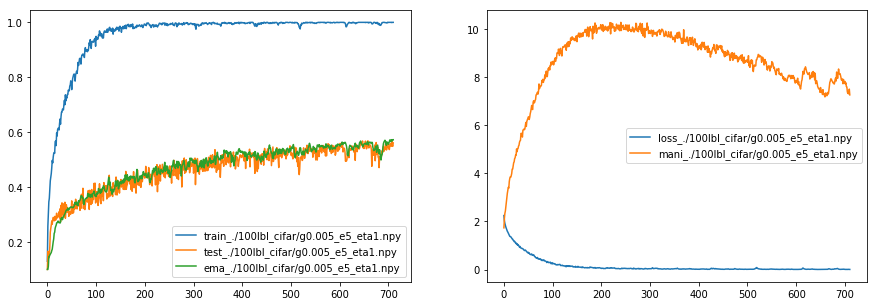

Epoch: 711,global_stp: 14240, xloss: 0.01154, maniloss: 7.19846, train: 99.90%, test: 56.16,test_ma: 57.15%
Epoch: 712,global_stp: 14260, xloss: 0.00820, maniloss: 7.17734, train: 100.00%, test: 56.07,test_ma: 57.21%
Epoch: 713,global_stp: 14280, xloss: 0.00695, maniloss: 7.45021, train: 100.00%, test: 56.37,test_ma: 57.15%
Epoch: 714,global_stp: 14300, xloss: 0.00523, maniloss: 7.28612, train: 100.00%, test: 56.45,test_ma: 56.76%
Epoch: 715,global_stp: 14320, xloss: 0.00659, maniloss: 7.26100, train: 100.00%, test: 56.79,test_ma: 56.97%
Epoch: 716,global_stp: 14340, xloss: 0.00618, maniloss: 7.16406, train: 100.00%, test: 56.69,test_ma: 57.09%
Epoch: 717,global_stp: 14360, xloss: 0.00546, maniloss: 7.00725, train: 100.00%, test: 56.68,test_ma: 56.88%
Epoch: 718,global_stp: 14380, xloss: 0.00763, maniloss: 6.94718, train: 100.00%, test: 56.87,test_ma: 56.96%
Epoch: 719,global_stp: 14400, xloss: 0.00771, maniloss: 6.96062, train: 100.00%, test: 55.25,test_ma: 56.55%
Epoch: 720,global_st

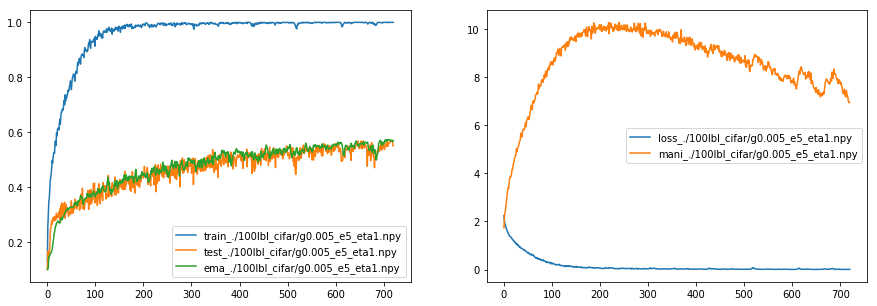

Epoch: 721,global_stp: 14440, xloss: 0.00695, maniloss: 6.94192, train: 100.00%, test: 57.40,test_ma: 56.92%
Epoch: 722,global_stp: 14460, xloss: 0.00600, maniloss: 7.01684, train: 100.00%, test: 56.20,test_ma: 56.81%
Epoch: 723,global_stp: 14480, xloss: 0.00695, maniloss: 7.04346, train: 100.00%, test: 56.95,test_ma: 56.71%
Epoch: 724,global_stp: 14500, xloss: 0.00680, maniloss: 6.94408, train: 100.00%, test: 56.05,test_ma: 56.43%
Epoch: 725,global_stp: 14520, xloss: 0.00944, maniloss: 6.89860, train: 100.00%, test: 56.37,test_ma: 56.77%
Epoch: 726,global_stp: 14540, xloss: 0.00783, maniloss: 6.97388, train: 100.00%, test: 56.17,test_ma: 55.93%
Epoch: 727,global_stp: 14560, xloss: 0.00725, maniloss: 6.96946, train: 100.00%, test: 56.37,test_ma: 56.28%
Epoch: 728,global_stp: 14580, xloss: 0.00786, maniloss: 6.90283, train: 100.00%, test: 55.61,test_ma: 56.04%
Epoch: 729,global_stp: 14600, xloss: 0.00719, maniloss: 6.96311, train: 100.00%, test: 55.40,test_ma: 56.86%
Epoch: 730,global_s

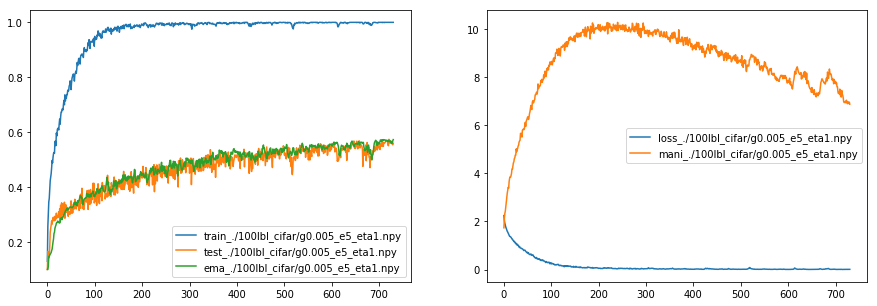

Epoch: 731,global_stp: 14640, xloss: 0.01092, maniloss: 6.97890, train: 100.00%, test: 55.33,test_ma: 56.43%
Epoch: 732,global_stp: 14660, xloss: 0.00923, maniloss: 6.99650, train: 99.90%, test: 55.05,test_ma: 55.65%
Epoch: 733,global_stp: 14680, xloss: 0.00703, maniloss: 7.03667, train: 100.00%, test: 56.28,test_ma: 56.19%
Epoch: 734,global_stp: 14700, xloss: 0.00773, maniloss: 7.07318, train: 100.00%, test: 55.63,test_ma: 55.63%
Epoch: 735,global_stp: 14720, xloss: 0.00687, maniloss: 6.99626, train: 100.00%, test: 54.37,test_ma: 56.25%
Epoch: 736,global_stp: 14740, xloss: 0.00898, maniloss: 6.87838, train: 100.00%, test: 56.18,test_ma: 56.92%
Epoch: 737,global_stp: 14760, xloss: 0.00716, maniloss: 6.95716, train: 100.00%, test: 55.34,test_ma: 56.72%
Epoch: 738,global_stp: 14780, xloss: 0.00643, maniloss: 6.93535, train: 100.00%, test: 55.57,test_ma: 57.09%
Epoch: 739,global_stp: 14800, xloss: 0.00505, maniloss: 6.92439, train: 100.00%, test: 55.73,test_ma: 56.97%
Epoch: 740,global_st

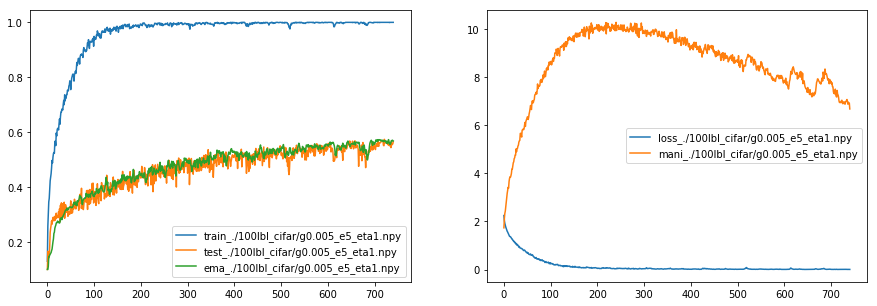

Epoch: 741,global_stp: 14840, xloss: 0.00696, maniloss: 6.69052, train: 100.00%, test: 56.26,test_ma: 56.70%
Epoch: 742,global_stp: 14860, xloss: 0.00821, maniloss: 6.69249, train: 100.00%, test: 55.68,test_ma: 56.55%
Epoch: 743,global_stp: 14880, xloss: 0.00830, maniloss: 6.74295, train: 100.00%, test: 55.69,test_ma: 56.50%
Epoch: 744,global_stp: 14900, xloss: 0.00712, maniloss: 6.74971, train: 100.00%, test: 55.62,test_ma: 56.63%
Epoch: 745,global_stp: 14920, xloss: 0.00690, maniloss: 6.65078, train: 100.00%, test: 56.65,test_ma: 56.27%
Epoch: 746,global_stp: 14940, xloss: 0.00661, maniloss: 6.65492, train: 100.00%, test: 56.37,test_ma: 56.42%
Epoch: 747,global_stp: 14960, xloss: 0.00796, maniloss: 6.82990, train: 100.00%, test: 55.63,test_ma: 56.44%
Epoch: 748,global_stp: 14980, xloss: 0.00767, maniloss: 6.68731, train: 100.00%, test: 56.65,test_ma: 56.47%
Epoch: 749,global_stp: 15000, xloss: 0.00760, maniloss: 6.81825, train: 100.00%, test: 56.30,test_ma: 55.19%
Epoch: 750,global_s

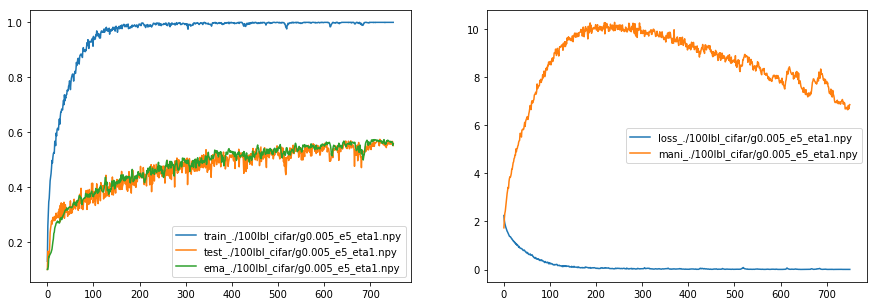

Epoch: 751,global_stp: 15040, xloss: 0.00918, maniloss: 6.65904, train: 100.00%, test: 56.10,test_ma: 56.07%
Epoch: 752,global_stp: 15060, xloss: 0.00750, maniloss: 6.71828, train: 100.00%, test: 55.17,test_ma: 55.82%
Epoch: 753,global_stp: 15080, xloss: 0.00642, maniloss: 6.84351, train: 100.00%, test: 54.62,test_ma: 55.71%
Epoch: 754,global_stp: 15100, xloss: 0.00708, maniloss: 6.69587, train: 100.00%, test: 55.60,test_ma: 56.21%
Epoch: 755,global_stp: 15120, xloss: 0.00494, maniloss: 6.70874, train: 100.00%, test: 56.91,test_ma: 56.78%
Epoch: 756,global_stp: 15140, xloss: 0.00757, maniloss: 6.67114, train: 100.00%, test: 56.15,test_ma: 56.71%
Epoch: 757,global_stp: 15160, xloss: 0.00788, maniloss: 6.43343, train: 100.00%, test: 56.40,test_ma: 56.36%
Epoch: 758,global_stp: 15180, xloss: 0.01077, maniloss: 6.67173, train: 100.00%, test: 55.76,test_ma: 56.35%
Epoch: 759,global_stp: 15200, xloss: 0.00908, maniloss: 6.86854, train: 100.00%, test: 56.39,test_ma: 56.58%
Epoch: 760,global_s

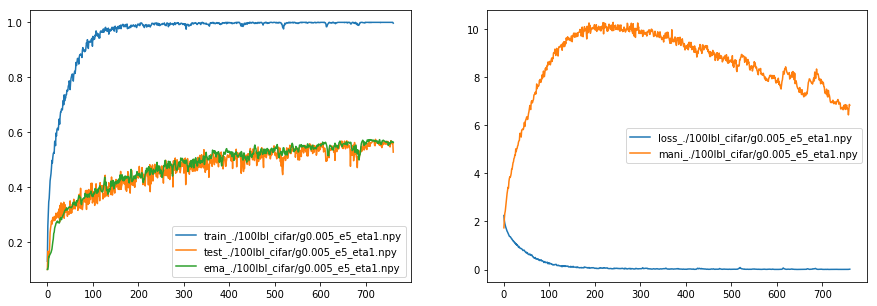

Epoch: 761,global_stp: 15240, xloss: 0.02920, maniloss: 7.03676, train: 99.50%, test: 52.49,test_ma: 56.77%
Epoch: 762,global_stp: 15260, xloss: 0.06328, maniloss: 7.20907, train: 98.40%, test: 49.04,test_ma: 55.16%
Epoch: 763,global_stp: 15280, xloss: 0.09365, maniloss: 7.72692, train: 97.10%, test: 44.53,test_ma: 51.18%
Epoch: 764,global_stp: 15300, xloss: 0.11547, maniloss: 7.79680, train: 96.80%, test: 50.34,test_ma: 50.11%
Epoch: 765,global_stp: 15320, xloss: 0.06665, maniloss: 7.81726, train: 98.80%, test: 51.36,test_ma: 49.69%
Epoch: 766,global_stp: 15340, xloss: 0.05600, maniloss: 8.10329, train: 98.60%, test: 52.78,test_ma: 50.18%
Epoch: 767,global_stp: 15360, xloss: 0.02974, maniloss: 8.21825, train: 99.50%, test: 46.21,test_ma: 50.04%
Epoch: 768,global_stp: 15380, xloss: 0.03108, maniloss: 8.13129, train: 99.20%, test: 53.42,test_ma: 51.51%
Epoch: 769,global_stp: 15400, xloss: 0.03961, maniloss: 8.18281, train: 99.00%, test: 52.39,test_ma: 51.14%
Epoch: 770,global_stp: 15420

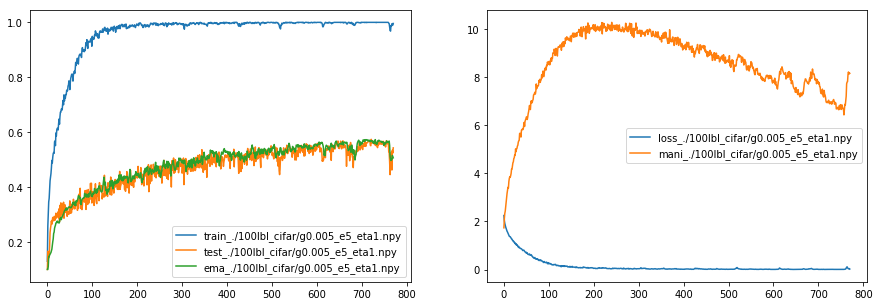

Epoch: 771,global_stp: 15440, xloss: 0.01607, maniloss: 7.99791, train: 99.90%, test: 53.86,test_ma: 50.30%
Epoch: 772,global_stp: 15460, xloss: 0.01067, maniloss: 8.17984, train: 100.00%, test: 52.12,test_ma: 51.73%
Epoch: 773,global_stp: 15480, xloss: 0.00817, maniloss: 8.18833, train: 99.90%, test: 51.80,test_ma: 53.96%
Epoch: 774,global_stp: 15500, xloss: 0.00967, maniloss: 7.80279, train: 100.00%, test: 54.27,test_ma: 55.13%
Epoch: 775,global_stp: 15520, xloss: 0.00684, maniloss: 7.70841, train: 100.00%, test: 55.13,test_ma: 54.45%
Epoch: 776,global_stp: 15540, xloss: 0.00698, maniloss: 7.82556, train: 100.00%, test: 54.94,test_ma: 55.21%
Epoch: 777,global_stp: 15560, xloss: 0.00678, maniloss: 7.71962, train: 100.00%, test: 55.06,test_ma: 56.13%
Epoch: 778,global_stp: 15580, xloss: 0.00615, maniloss: 7.56316, train: 100.00%, test: 55.39,test_ma: 56.36%
Epoch: 779,global_stp: 15600, xloss: 0.00605, maniloss: 7.41026, train: 100.00%, test: 55.32,test_ma: 56.55%
Epoch: 780,global_stp

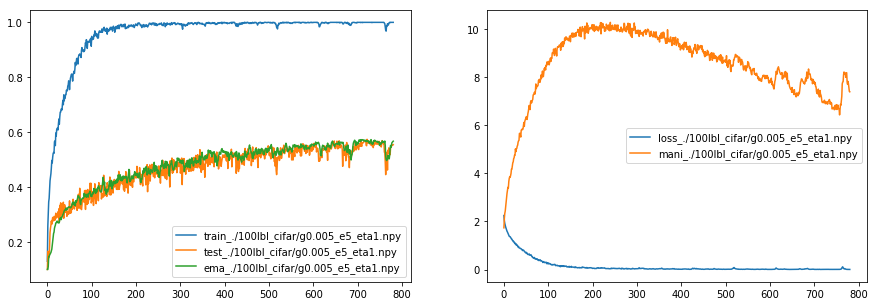

Epoch: 781,global_stp: 15640, xloss: 0.00629, maniloss: 7.29692, train: 100.00%, test: 56.38,test_ma: 56.87%
Epoch: 782,global_stp: 15660, xloss: 0.00540, maniloss: 7.26999, train: 100.00%, test: 56.93,test_ma: 57.09%
Epoch: 783,global_stp: 15680, xloss: 0.00635, maniloss: 7.34893, train: 100.00%, test: 56.19,test_ma: 56.66%
Epoch: 784,global_stp: 15700, xloss: 0.00565, maniloss: 7.24216, train: 100.00%, test: 56.06,test_ma: 56.55%
Epoch: 785,global_stp: 15720, xloss: 0.00745, maniloss: 6.97773, train: 100.00%, test: 55.55,test_ma: 56.86%
Epoch: 786,global_stp: 15740, xloss: 0.00670, maniloss: 7.03599, train: 100.00%, test: 56.00,test_ma: 57.34%
Epoch: 787,global_stp: 15760, xloss: 0.00680, maniloss: 7.02233, train: 100.00%, test: 56.92,test_ma: 57.60%
Epoch: 788,global_stp: 15780, xloss: 0.00712, maniloss: 6.89324, train: 100.00%, test: 55.50,test_ma: 57.31%
Epoch: 789,global_stp: 15800, xloss: 0.00760, maniloss: 6.86094, train: 100.00%, test: 56.00,test_ma: 57.64%
Epoch: 790,global_s

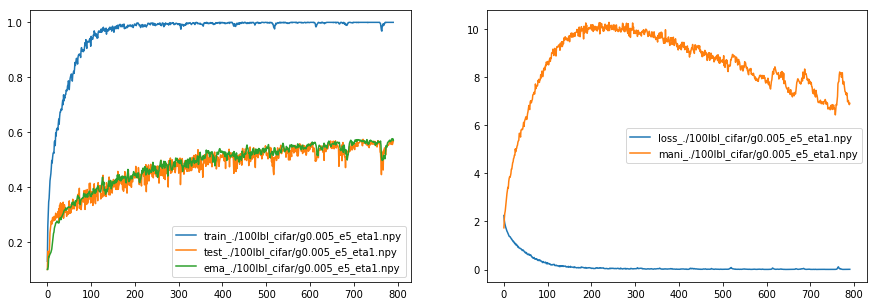

Epoch: 791,global_stp: 15840, xloss: 0.00982, maniloss: 6.90770, train: 100.00%, test: 55.77,test_ma: 57.22%
Epoch: 792,global_stp: 15860, xloss: 0.00630, maniloss: 7.07130, train: 100.00%, test: 57.10,test_ma: 57.13%
Epoch: 793,global_stp: 15880, xloss: 0.00759, maniloss: 6.83569, train: 100.00%, test: 56.52,test_ma: 57.03%
Epoch: 794,global_stp: 15900, xloss: 0.00794, maniloss: 7.03751, train: 100.00%, test: 55.76,test_ma: 56.97%
Epoch: 795,global_stp: 15920, xloss: 0.00787, maniloss: 6.86012, train: 100.00%, test: 56.31,test_ma: 56.76%
Epoch: 796,global_stp: 15940, xloss: 0.00665, maniloss: 6.86965, train: 100.00%, test: 56.00,test_ma: 56.77%
Epoch: 797,global_stp: 15960, xloss: 0.00626, maniloss: 6.72533, train: 100.00%, test: 56.43,test_ma: 57.22%
Epoch: 798,global_stp: 15980, xloss: 0.00746, maniloss: 6.91326, train: 100.00%, test: 56.92,test_ma: 57.20%
Epoch: 799,global_stp: 16000, xloss: 0.00680, maniloss: 6.68612, train: 100.00%, test: 57.33,test_ma: 57.62%
Epoch: 800,global_s

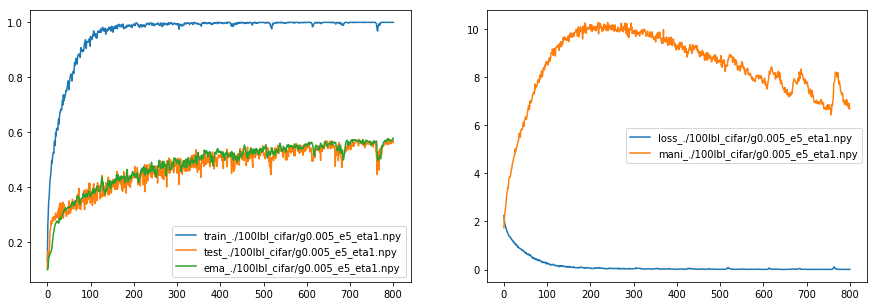

In [26]:
for epoch in tqdm(range(params_dnn['epoch'])):
    inds = rng.permutation(trainx.shape[0])
    trainx = trainx[inds]
    trainy = trainy[inds]
    train_acc=test_acc=train_loss=train_manifold=test_acc_ema=0
    
    for step in range(nr_batch_train):
        ran_from = step * params_dnn['batch']
        ran_to = (step+1) * params_dnn['batch']
        xl, _ , acc,ml =  sess.run([xloss,train_op, accuracy,manifold_loss], {inp: trainx[ran_from:ran_to],
                                                                             lbl: trainy[ran_from:ran_to],
                                                                             is_training_pl:False,
                                                                             training_cnn:True})
        train_acc += acc; train_loss += xl; train_manifold += ml
    train_acc /= nr_batch_train; train_loss /= nr_batch_train; train_manifold /= nr_batch_train
    train_array.append(train_acc);loss_array.append(train_loss);manifold_array.append(train_manifold)
    for step in range(nr_batch_test):
        ran_from = step * params_dnn['batch']
        ran_to = (step+1) * params_dnn['batch']
        acc,acc_ema = sess.run([accuracy,accuracy_ema], {inp: testx[ran_from:ran_to],
                                         lbl: testy[ran_from:ran_to],
                                         training_cnn:False})
        test_acc += acc; test_acc_ema += acc_ema
    test_acc /= nr_batch_test; test_acc_ema /=nr_batch_test
    test_array.append(test_acc);test_array_ema.append(test_acc_ema)
    
    print("Epoch: {},global_stp: {}, xloss: {:.5f}, maniloss: {:.5f}, train: {:.2f}%, test: {:.2f},test_ma: {:.2f}%".format(
            epoch, sess.run(global_step),train_loss, train_manifold,train_acc * 100,test_acc*100, test_acc_ema*100))
    
    if  (epoch % 10 == 0):
        np.save(name_experiment,{'train': train_array,
        'test' : test_array,
        'ema' : test_array_ema,
        'loss' : loss_array,
        'mani' : manifold_array,
        'name':name_experiment})
        
        plot_dics([np.load(name_experiment)])
        plt.show()

In [ ]:
ls